#### Imports

In [3]:
from datetime import timedelta, datetime
import json
import pprint
from copy import deepcopy
import pytz

import cufflinks
cufflinks.go_offline()
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from tqdm.notebook import tqdm

import sys

import os
 
# Path to the folder containing the alternate version of PyRecoy

alternate_pyrecoy_path = 'C:\\Users\\z004yn8c\\OneDrive - Siemens AG\\Documents\\GitHub\\Mooi-Kickstart\\pyrecoy\\pyrecoy'
 
# Add the path to sys.path

if alternate_pyrecoy_path not in sys.path:

    sys.path.insert(0, alternate_pyrecoy_path)
 
# Now import PyRecoy

import pyrecoy2

# Check the version or path to confirm

print(pyrecoy2.__file__)


from pyrecoy2.assets import Heatpump, Eboiler, GasBoiler, HotWaterStorage
from pyrecoy2.colors import *
from pyrecoy2.converters import *
from pyrecoy2.financial import calculate_eb_ode, get_tax_tables, get_tax_rate, get_grid_tariffs_electricity
from pyrecoy2.framework import TimeFramework
from pyrecoy2.casestudy import CaseStudy
from pyrecoy2.plotting import ebitda_bar_chart, npv_bar_chart
from pyrecoy2.reports import CaseReport, ComparisonReport, BusinessCaseReport, SingleFigureComparison
from pyrecoy2.sensitivity import SensitivityAnalysis
from pyrecoy2.prices import get_tennet_data, get_afrr_capacity_fees_nl
from pyrecoy2.forecasts import Mipf, Forecast

%load_ext autoreload
%autoreload 2

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\__init__.py


#### Development backlog

* aFRR (can improve the optimisation case)
* Report
* COP seems to have fix values, rather than COP curve

#### Meeting Notes

##### Meeting 25-11-2020

* aFRR can help optimisation case
* SDE++ should be included
* Tsource sensitivity really gives interesting insights
* Sensitivities should be verified (especially CO2, Tsink, Tsource, time period)
* AP TNO: Update/verify COP curve
* AP TNO: Update CAPEX
* AP Mark: 
    * Create graphs on COP curve with different Tsource, Tsink
    * Generate table and output in .csv (send it to Andrew)
* Investigate opportunity to lower the COP and negative electricity prices
    * Technically feasible, but not really needed/possible to do it in this project
* Could be interesting to run this model on a usecase with higher delta T
* Conclusion: Finalize this model, but not add too much extra complexity, next steps is to go towards industrial partners with the results

# Kickstart: Heatpump Optimisation Framework

***
© Shahla Huseynova  
July 2024
##### Cases
In this model, 4 cases are compared:
* **Baseline** : All heat is supplied by steam turbine
* **Heatpump case** : All heat is supplied by heatpump
* **Hybrid case** : Steam boiler and heatpump run in hybrid mode, and are optimised on costs in real-time
* **Heat pump & storage cases**: Heat pump only case is compared with different setup of storage +heat pump cases

#### Loading config

In [11]:
class Config():
    start = '2023-01-01'
    end = '2023-12-31'
    # year = '2019'
    # startdate = year + '-01-01'
    # enddate = str(year) + '-12-31'
    # start = datetime.strptime(startdate, "%Y-%m-%d").astimezone(pytz.timezone('Europe/Amsterdam'))
    # end = datetime.strptime(enddate, "%Y-%m-%d").astimezone(pytz.timezone('Europe/Amsterdam'))
    # start = start.astimezone(pytz.UTC)
    # end = end.astimezone(pytz.UTC)
    
    hp_vdg_e_power = 1.5 # MW
    # hp_ndg_e_power = 7.7 # MW
    hp_min_load = 0
    hp_lifetime = 25
    hp_capex = 200_000 # EUR/MWth
    hp_opex = 0.01 # in % of CAPEX
    hp_devex = 0.005 # in % of CAPEX
    
    gb_power = 5 # MW
    gb_efficiency = 0.9
    
    storage_power = 25
    storage_volume = 1000
    storage_cap_per_volume = 50 * 1e-3
    storage_lifetime = 25
    storage_temperature = 95
    storage_min_level = storage_volume * storage_cap_per_volume * 0.05
    storage_capex_per_MW = 7_000
    storage_capex_per_MWh = 5_000
    storage_opex_perc_of_capex = 0.02
    # storage_initial_level = 5
    threshold = 20
    
    tax_bracket_g = 4 
    tax_bracket_e = 4
    
    include_transport_costs = False
    grid_operator = 'Liander'
    connection_type = 'TS/MS'
    
    discount_rate = 0.1
    project_duration = 12

    forecast = 'ForeNeg'
    gas_price_multiplier = 1
    e_price_multiplier = 1
    e_price_volatility_multiplier = 1
    co2_price_multiplier = 1
    tsource_delta = 0
    tsink_delta = 0
    energy_tax_multiplier = 1
    
    # Review the SDE implementation
    sde_base_amount = 81
    longterm_gas_price = 24.00
    longterm_co2_price = 37.90
    sde_switch_price_correction = 40
    
    day_ahead_buying_perc = 0.3
    
    afrr_capacity_fee = 25_000

c = Config()

In [12]:
class Store():
    pass

## Model set-up

In [14]:
# Define the file paths
excel_file_path = r'C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\Kickstart\V2\Demand_Data_Smurfit_Preprocessed3.xlsx'
output_directory = r'C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\Kickstart\V2\data'
output_file_name = 'smurfit_demand_preprocessed3.csv'
csv_file_path = os.path.join(output_directory, output_file_name)

df = pd.read_excel(excel_file_path)
# df = df.fillna(0) 

# # Save the DataFrame to CSV
df.to_csv(csv_file_path, index=False)

In [15]:
def load_demand_data(c, s):
    demand = pd.read_csv('data/smurfit_demand_preprocessed3.csv', delimiter=',', decimal='.')
    dt_index = pd.date_range(
        start=s.time_fw.start,
        end=s.time_fw.start + timedelta(days=365), 
        freq='1T',
        tz='Europe/Amsterdam')
    dt_index = dt_index[:len(demand)]
    demand.index = dt_index
    demand['Total demand'] = demand['MW (VDG)']
    demand = demand[c.start:c.end]
    return demand

In [16]:
s = Store()

In [17]:
def setup_model(c):
    s = Store()
    
    s.time_fw = TimeFramework(start=c.start, end=c.end)
    # s.minute_ix = s.time_fw.dt_index(freq='1T')
    mipf = Mipf(None, start=s.time_fw.start, end=s.time_fw.end, from_database=True, add_days_to_start_end=False).data
    s.mipf = mipf
    s.baseline = CaseStudy(time_fw=s.time_fw, freq='1T', name='Baseline')
    s.hpcase = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump only', data=mipf)
    #s.hpcase_sde = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + SDE', data=mipf)
    #s.optcase1 = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation', data=mipf)
    #s.afrr_case = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation + aFRR', data=mipf)
    s.storage_case_PCM = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + Storage_PCM', data=mipf)
    # s.storage_case_TCM = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + Storage_TCM', data=mipf)
    # s.storage_case_battery = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + Storage_battery', data=mipf)
    s.cases = list(CaseStudy.instances.values())
    #s.optcases = [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case]
    s.optcases = [s.hpcase, s.storage_case_PCM]
    #s.sde_cases = [s.hpcase_sde, s.optcase1, s.afrr_case]
    s.sde_cases = []
    
    s.demand = load_demand_data(c, s)
    return s

s = setup_model(c)

testetss


C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:41: UserWarning:

The chosen timeperiod spans 365.99930555555557 days, which is not a full year. Beware that certain functions that use yearly rates might return incorrect values.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\forecasts.py:62: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\forecasts.py:115: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:54: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Moo

In [18]:
# s.demand.resample('15T').mean()[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [19]:
s.demand.describe()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  Total demand
count        52560.0      52560.0   52560.0       52560.0
mean            70.0        144.0       1.0           1.0
std              0.0          0.0       0.0           0.0
min             70.0        144.0       1.0           1.0
25%             70.0        144.0       1.0           1.0
50%             70.0        144.0       1.0           1.0
75%             70.0        144.0       1.0           1.0
max             70.0        144.0       1.0           1.0

## Load in data

In [21]:
def add_afrr_prices(c, case):
    try:
        aFRR_signal = pd.read_csv(f'data/aFRR_{c.start}.csv', delimiter=';', decimal=',', index_col='datetime')
        aFRR_signal.index = case.data.index
    except:
        data = get_tennet_data('balansdelta2017', pd.to_datetime(c.start), pd.to_datetime(c.end))
        data.index = data[["datum", "tijd"]].apply(lambda x: " ".join(x), axis=1)
        data.index = pd.to_datetime(data.index, format="%d-%m-%Y %H:%M").tz_localize(
            "Europe/Amsterdam", ambiguous=True
        )
        data = data[~data.index.duplicated(keep="first")]
        date_ix = pd.date_range(
            data.index[0], data.index[-1], freq="1T", tz="Europe/Amsterdam"
        )
        data = data.reindex(date_ix)
        aFRR_signal = data[['Hoogste_prijs_opregelen', 'Mid_prijs_opregelen', 'Laagste_prijs_afregelen']]
        aFRR_signal.to_csv(f'data/aFRR_{c.start}.csv', sep=';', decimal=',', index_label='datetime')

    try:
        aFRR_prices = pd.read_csv(f'data/aFRR_prices_{c.start}.csv', delimiter=';', decimal=',', index_col='datetime')
        aFRR_prices.index = case.data.index
    except:
        data = get_aFRR_prices_nl(pd.to_datetime(c.start), pd.to_datetime(c.end))
        data.index = pd.date_range(
            start=c.start,
            end=pd.to_datetime(c.end) + timedelta(days=1),
            tz='Europe/Amsterdam', 
            freq='15T', 
            closed='left'
        )
        aFRR_prices = data.reindex(case.data.index, method='ffill')
        aFRR_prices.to_csv(f'data/aFRR_prices_{c.start}.csv', sep=';', decimal=',', index_label='datetime')
        
    case.data = pd.concat([case.data, aFRR_signal, aFRR_prices], axis=1)
    return case

In [22]:
def increase_volatility_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    new_diff = diff_to_mean * factor
    return mean + new_diff

def multiply_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    
    cond = diff_to_mean > 0
    diff_to_mean[cond] *= factor
    diff_to_mean[~cond] /= factor
    return mean + diff_to_mean

In [23]:
def load_data(c, s):
    if hasattr(s, 'afrr_case'):
        s.afrr_case = add_afrr_prices(c, s.afrr_case)
    
    for case in s.cases:
        case.add_gasprices()
        case.add_co2prices(perMWh=True)
        
        case.data['Gas prices (€/MWh)'] *= c.gas_price_multiplier
        case.data['CO2 prices (€/MWh)'] *= c.co2_price_multiplier
        case.data['CO2 prices (€/ton)'] *= c.co2_price_multiplier
        
    for case in s.optcases:
        case.data['NEG'] = multiply_by_factor(case.data['NEG'], c.e_price_multiplier)
        case.data['ForeNeg'] = multiply_by_factor(case.data['ForeNeg'], c.e_price_multiplier)
        case.data['DAM'] = multiply_by_factor(case.data['DAM'], c.e_price_multiplier)
        
        case.data['NEG'] = increase_volatility_by_factor(case.data['NEG'], c.e_price_volatility_multiplier)
        case.data['ForeNeg'] = increase_volatility_by_factor(case.data['ForeNeg'], c.e_price_volatility_multiplier)
    
    if hasattr(s, 'afrr_case'):
        for case in [s.afrr_case]:
            case.data['Hoogste_prijs_opregelen'] = multiply_by_factor(case.data['Hoogste_prijs_opregelen'], c.e_price_multiplier)
            case.data['Hoogste_prijs_opregelen'] = increase_volatility_by_factor(case.data['Hoogste_prijs_opregelen'], c.e_price_volatility_multiplier)
            case.data['aFRR_up'] = multiply_by_factor(case.data['aFRR_up'], c.e_price_multiplier)
            case.data['aFRR_up'] = increase_volatility_by_factor(case.data['aFRR_up'], c.e_price_volatility_multiplier)

    s.demand['Tsource (VDG)'] += c.tsource_delta
    s.demand['Tsink (VDG)'] += c.tsink_delta
    for case in s.cases:
        case.data = pd.concat([case.data, s.demand], axis=1)        

    s.eb_ode_g = get_tax_rate('gas', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.eb_ode_e = get_tax_rate('electricity', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.grid_fees = get_grid_tariffs_electricity(c.grid_operator, 2020, c.connection_type)
    s.grid_fee_per_MWh = s.grid_fees['kWh tarief'] * 1000
    return s

s = load_data(c, s)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecate

In [24]:
s.hpcase.data.head()

DAM    POS    NEG  ForeNeg  ForePos  \
2023-01-01 00:00:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:01:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:02:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:03:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:04:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   

                           Gas prices (€/MWh)  CO2 prices (€/ton)  \
2023-01-01 00:00:00+01:00              63.998                5.23   
2023-01-01 00:01:00+01:00              63.998                5.23   
2023-01-01 00:02:00+01:00              63.998                5.23   
2023-01-01 00:03:00+01:00              63.998                5.23   
2023-01-01 00:04:00+01:00              63.998                5.23   

                           CO2 prices (€/MWh)  Tsource (VDG)  Tsink (VDG)  \
2023-01-01 00:00:00+01:00                1.01           70.0        144.0   
2023-01-01 00:01:00+01:00                1.01           70.0        144.0   
2023-01-01 00:02:00+01:00                1.01           70.0        144.0   
2023-01-01 00:03:00+01:00                1.01           70.0        144.0   
2023-01-01 00:04:00+01:00                1.01           70.0        144.0   

                           MW (VDG)  Total demand  
2023-01-01 00:00:00+01:00       1.0           1.0  
2023-01-01 00:01:00+01:00       1.0           1.0  
2023-01-01 00:02:00+01:00       1.0           1.0  
2023-01-01 00:03:00+01:00       1.0           1.0  
2023-01-01 00:04:00+01:00       1.0           1.0

## Assets

### COP curve

In [27]:
def cop_curve(Tsink, Tsource):
    Tsink += 273
    Tsource += 273

    c1 = 0.267 * Tsink / (Tsink - Tsource)
    c2 = 0.333 * Tsink / (Tsink - Tsource)
    
    return Polynomial([c2, c1])

In [28]:
cop_curve(140, 13)

Polynomial([1.08290551, 0.86827559], domain=[-1,  1], window=[-1,  1], symbol='x')

In [29]:
cop_curve(140, 73)

Polynomial([2.05267164, 1.64583582], domain=[-1,  1], window=[-1,  1], symbol='x')

In [30]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve
)

In [31]:
#heatpump.get_cop(heat_output=load, Tsink=140, Tsource=13)

In [32]:
#heatpump.get_cop(heat_output=load, Tsink=140, Tsource=99)

In [33]:
import itertools

source_Ts = np.arange(25, 75) + 273
sink_Ts   = np.arange(80, 170) + 273

df = pd.DataFrame(columns=list(sink_Ts), index=list(source_Ts))
for sourceT, sinkT in itertools.product(source_Ts, sink_Ts):
    df.loc[sourceT, sinkT] = heatpump.get_cop(heat_output=0.5, Tsink=sinkT, Tsource=sourceT)
    
#df.to_csv('cops_at_50perc_load.csv', sep=';', decimal=',')

In [34]:
sourceT = 63 + 273
sinkT = 140 + 273
loads = np.arange(0, 1, 0.01)

cop_series = pd.Series(index=loads, dtype='float')
load_series = pd.Series(index=loads, dtype='float')
for load in loads:
    cop = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT)
    cop_series[load] = cop
    load_series[load] = load / cop 

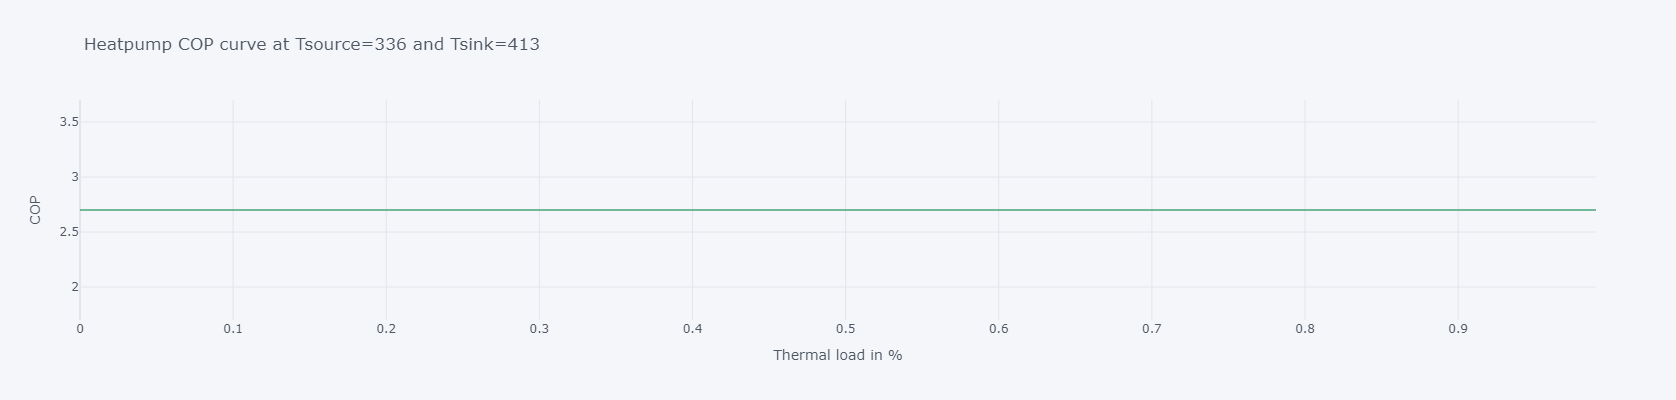

In [35]:
fig_cop_curve = cop_series.iplot(title=f'Heatpump COP curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='COP', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_cop_curve

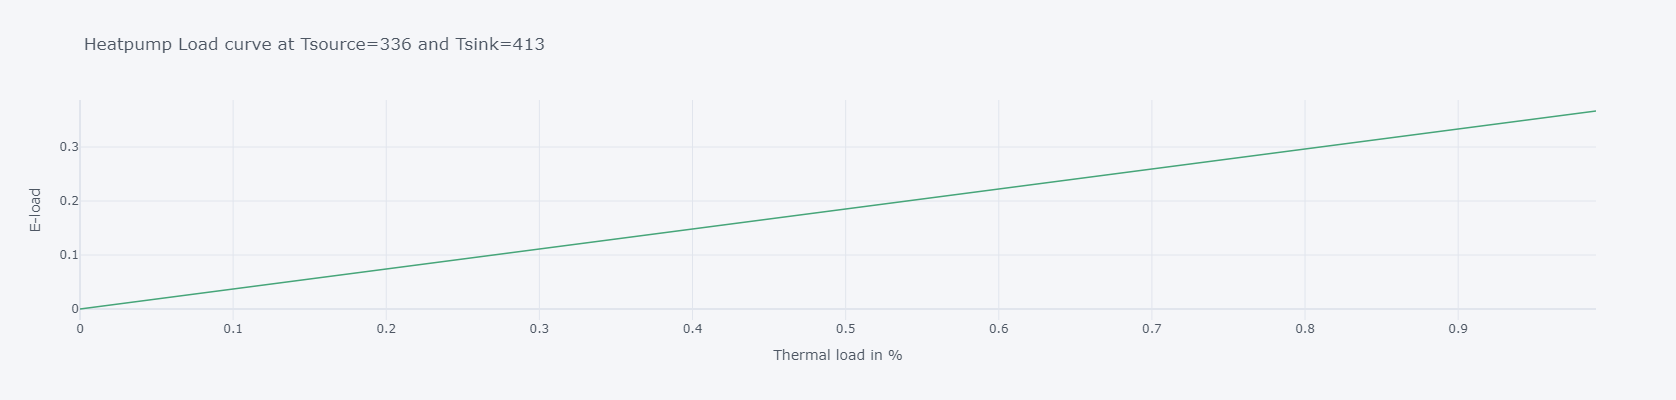

In [36]:
fig_load_curve = load_series.iplot(title=f'Heatpump Load curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='E-load', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_load_curve

In [37]:
def cop_curve_new(Tsink, Tsource):
    Tsink += 273
    Tsource += 273
    Tlift = Tsink - Tsource

    c0 = 0.0005426*Tlift**2 - 0.1178*Tlift + 6.962
    c1 = 6.7058 
    c2 = -1.79
    
    return Polynomial([c0, c1, c2])

In [38]:
sourceT = 63 + 273
sinkT = 140 + 273
cop_curve_new(sourceT, sinkT)

Polynomial([19.2496754,  6.7058   , -1.79     ], domain=[-1,  1], window=[-1,  1], symbol='x')

In [39]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve_new
)

In [40]:
import itertools

source_Ts = np.arange(25, 75) + 273
sink_Ts   = np.arange(80, 170) + 273

df = pd.DataFrame(columns=list(sink_Ts), index=list(source_Ts))
for sourceT, sinkT in itertools.product(source_Ts, sink_Ts):
    df.loc[sourceT, sinkT] = heatpump.get_cop(heat_output=0.5, Tsink=sinkT, Tsource=sourceT)
    
#df.to_csv('cops_at_50perc_load.csv', sep=';', decimal=',')

In [41]:
sourceT = 63 + 273
sinkT = 140 + 273
loads = np.arange(0, 1, 0.01)

cop_series = pd.Series(index=loads, dtype='float')
load_series = pd.Series(index=loads, dtype='float')
for load in loads:
    cop = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT)
    cop_series[load] = cop
    load_series[load] = load / cop 

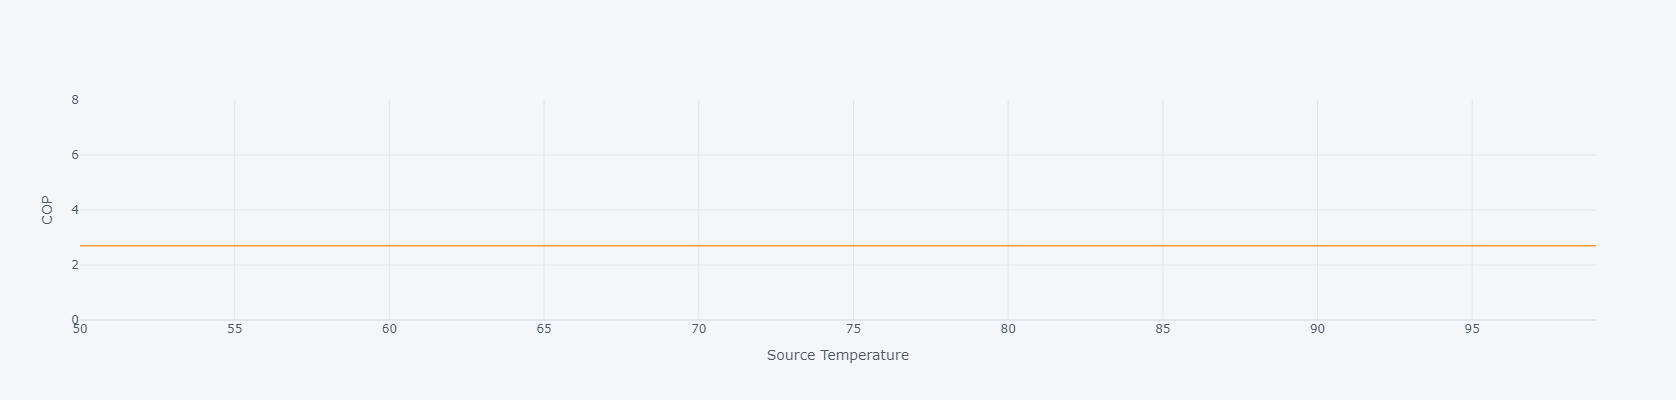

In [42]:
sourceTs = np.arange(50, 100)
sinkT = 140 + 273
load = 1 
cop_series = pd.Series(index=sourceTs, dtype='float')

for sourceT in sourceTs:
    cop = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT + 273)
    cop_series[sourceT] = cop
    
cop_series.iplot(yrange=[0, 8], xTitle='Source Temperature', yTitle='COP', dimensions=(800, 400))

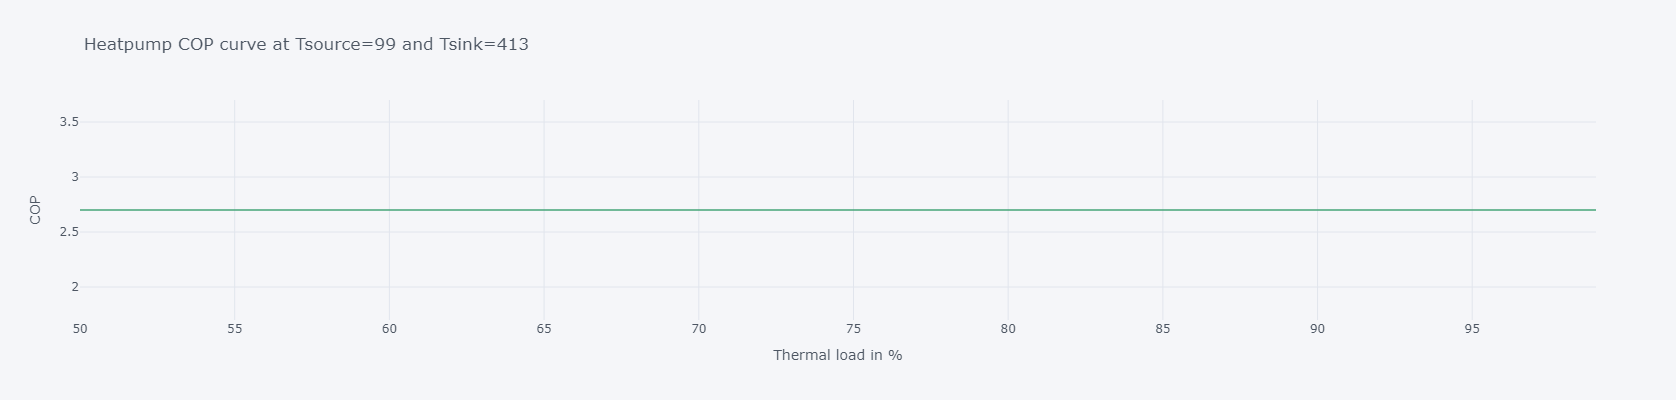

In [43]:
fig_cop_curve = cop_series.iplot(title=f'Heatpump COP curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='COP', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_cop_curve

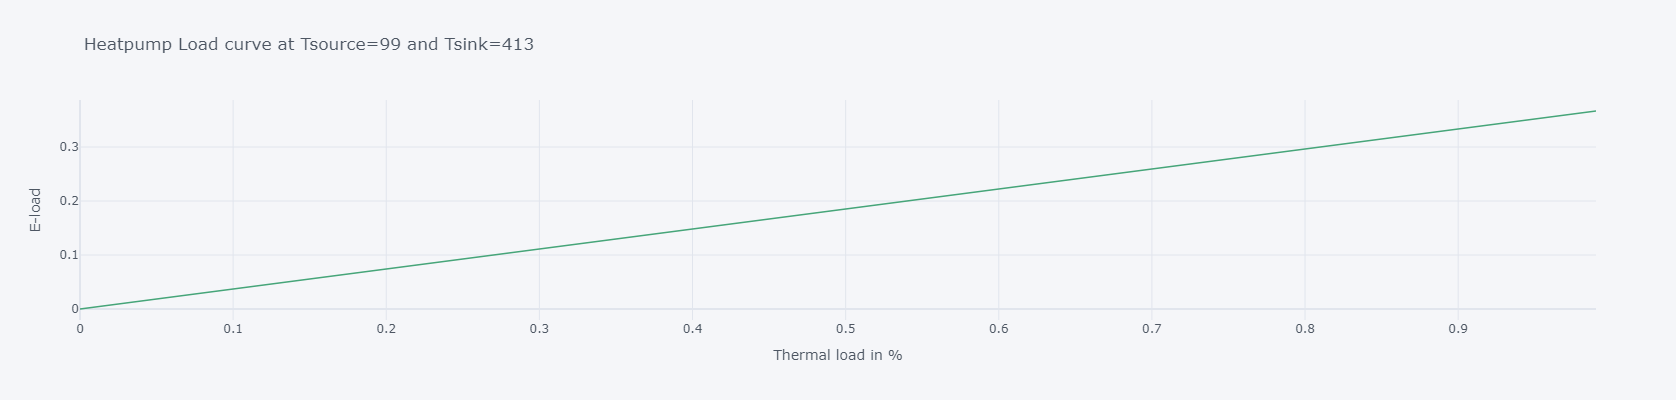

In [44]:
fig_load_curve = load_series.iplot(title=f'Heatpump Load curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='E-load', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_load_curve

### Create and assign assets

In [46]:
def create_and_assign_assets(c, s):
    heatpump_vdg = Heatpump(
        name='Heatpump VDG',
        max_th_power=c.hp_vdg_e_power,
        min_th_power=c.hp_vdg_e_power * c.hp_min_load,
        cop_curve=cop_curve_new
    )


    capex_vdg = c.hp_capex*(heatpump_vdg.max_th_power) 
    heatpump_vdg.set_financials(capex=capex_vdg, opex=c.hp_opex*capex_vdg, devex=c.hp_devex*capex_vdg, lifetime=25)

    gasboiler = GasBoiler(
        name='Gasboiler',
        max_th_output=c.gb_power,
        efficiency=c.gb_efficiency
    )
    gasboiler.set_financials(capex=0, opex=0, devex=0, lifetime=25)
    
    waterstorage = HotWaterStorage(
        name='HotWaterStorage',
        rated_power=c.storage_power, 
        capacity_per_volume=c.storage_cap_per_volume,
        volume=c.storage_volume, 
        temperature=c.storage_temperature,
        min_storagelevel=c.storage_min_level,
        # initial_storagelevel=c.storage_initial_level
    )
    capex_ws = c.storage_capex_per_MW * waterstorage.max_power + c.storage_capex_per_MWh * waterstorage.capacity
    opex_ws = c.storage_opex_perc_of_capex * capex_ws
    waterstorage.set_financials(capex=capex_ws, opex=opex_ws, devex=0, lifetime=c.storage_lifetime)
    
    s.baseline.add_asset(gasboiler)
    s.hpcase.add_asset(heatpump_vdg)
    s.storage_case_PCM.add_asset(heatpump_vdg)
    s.storage_case_PCM.add_asset(waterstorage)
#     s.hpcase_sde.add_asset(heatpump_vdg)
#     s.optcase1.add_asset(heatpump_vdg)
#     s.optcase1.add_asset(gasboiler)
#     s.afrr_case.add_asset(heatpump_vdg)
#     s.afrr_case.add_asset(gasboiler)
    return s

s = create_and_assign_assets(c, s)

In [47]:
s.storage_case_PCM.assets['HotWaterStorage']

HotWaterStorage(name=HotWaterStorage, rated_power=25, capacity=50.0, temperature=95, min_storagelevel=2.5)

## Optimization

### Strategies

In [50]:
def baseline_sim(case):
    gasboiler = list(case.assets.values())[0]
    data = case.data
    demand = (data['MW (VDG)']).to_list()

    minutes = iter(range(len(case.data)))
    th_output = [0] * len(case.data)
    gas_input = [0] * len(case.data)

    for m in minutes:
        th_output[m], gas_input[m] = gasboiler.set_heat_output(demand[m])

    data['output_MW_th'] = np.array(th_output)
    data['output_MWh_th'] = np.array(data['output_MW_th']/60)
    data['gb_input_MW'] = np.array(gas_input)
    data['gb_input_MWh'] = np.array(data['gb_input_MW']/60)
    case.data = data.round(5)
    return case

In [51]:
def hponly(case):
    hp_vdg = case.assets['Heatpump VDG']
    demand_vdg = case.data['MW (VDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()

    hp_vdg_input = [0] * len(case.data)
    hp_vdg_output = [0] * len(case.data)

    minutes = iter(range(len(case.data)))
    for m in minutes:
        demand = demand_vdg[m]
        if demand != 0:
            hp_vdg_input[m], hp_vdg_output[m] = hp_vdg.set_heat_output(
                heat_output=demand,
                Tsink=Tsink_vdg[m],
                Tsource=Tsource_vdg[m]
            )

    case.data['hp_output_MW'] = np.array(hp_vdg_output)
    case.data['hp_input_MW'] = np.array(hp_vdg_input)
    case.data['cop'] = case.data['hp_output_MW'] / -case.data['hp_input_MW']
    
    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(3)
    return case

In [52]:
Tref = 0
Cp = 4190  #J/kgK
MWtoJs = 1000_000

def power_to_mass_flow(power_MW, Tsink, Tref, Cp):
    return power_MW * MWtoJs /(Cp*(Tsink - Tref))
def energy_to_storage(hp_heat_output_MW, process_demand_MW):
    return hp_heat_output_MW - process_demand_MW  #MW

def Tsource_calculation(Tstorage, discharge_power, Tsource, process_mass_flow):   
    discharge_mass_flow = power_to_mass_flow(discharge_power, Tstorage, Tref, Cp)
    
    combined_mass_flow = (discharge_mass_flow + process_mass_flow)
    if combined_mass_flow == 0:
        return Tsource
    else: 
        return (Tstorage * discharge_mass_flow + Tsource * process_mass_flow) / combined_mass_flow

In [53]:
def hp_storage_opt_enginge(c, ws, hp_vdg, pos, neg, dam, demand_vdg, tsource_vdg, tsink_vdg):
    
    from_storage_vdg_MW = 0
    to_storage_vdg_MW = 0  
    
    if neg < dam - c.threshold:
        # overproduce
        if demand_vdg != 0:
            desired_hp_load_vdg = min(demand_vdg + ws.charging_power_limit, hp_vdg.max_th_power)
            e_load_vdg, th_load_vdg = hp_vdg.set_heat_output(desired_hp_load_vdg, tsink_vdg, tsource_vdg)

            to_storage_vdg_MW = th_load_vdg - demand_vdg
            to_storage_vdg_MW = -ws.charge(round(to_storage_vdg_MW, 3))

            extra_charging_power_constraint = ws.max_power - to_storage_vdg_MW
        else:
            e_load_vdg, th_load_vdg = (0,0)
            
            

    elif pos > dam + c.threshold:
        # take from storage
        if demand_vdg != 0:
            from_process_massflow_vdg = power_to_mass_flow(demand_vdg, tsink_vdg, Tref, Cp)
            try:
                from_storage_vdg_MW = ws.discharging_power_limit
                tsource_vdg = Tsource_calculation(ws.temperature, from_storage_vdg_MW, tsource_vdg, from_process_massflow_vdg)
                e_load_vdg, th_load_vdg = hp_vdg.set_heat_output(demand_vdg, tsink_vdg, tsource_vdg)
            except: 
                from_storage_vdg_MW = 0
                tsource_vdg = Tsource_calculation(ws.temperature, from_storage_vdg_MW, tsource_vdg, from_process_massflow_vdg)
                e_load_vdg, th_load_vdg = hp_vdg.set_heat_output(demand_vdg, tsink_vdg, tsource_vdg)

            from_storage_vdg_MW = ws.discharge(round(from_storage_vdg_MW, 3))
        else:
            e_load_vdg, th_load_vdg = (0,0)
            
        #print({f'from_storage_vdg_MW='})
    else:
        e_load_vdg, th_load_vdg = hp_vdg.set_heat_output(
            heat_output=demand_vdg,
            Tsink=tsink_vdg,
            Tsource=tsource_vdg
        )

    return e_load_vdg, th_load_vdg, tsource_vdg, to_storage_vdg_MW, from_storage_vdg_MW, ws, hp_vdg
# Neg-take price, Pos-feed price

In [54]:
def hponly_with_storage(case):
    hp_vdg = case.assets['Heatpump VDG']
    ws = case.assets['HotWaterStorage']
    demands_vdg = case.data['MW (VDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()
    dam_prices = case.data['DAM'].to_list()
    pos_prices = case.data['POS'].to_list()
    neg_prices = case.data['NEG'].to_list()

    hp_vdg_input = [0] * len(case.data)
    hp_vdg_output = [0] * len(case.data)

    minutes = len(case.data)
    storage_levels = [None] * minutes
    to_storage_list = [0] * minutes
    from_storage_vdg_list = [0] * minutes
    to_storage_vdg_list = [0] * minutes

    new_tsources_vdg = case.data['Tsource (VDG)'].to_list()

    
    ws.set_chargelevel(ws.min_chargelevel)
    
    for m in range(minutes):
        tsource_vdg = Tsource_vdg[m]
        tsink_vdg = Tsink_vdg[m]
        demand_vdg = demands_vdg[m]
        
        e_load_vdg, th_load_vdg, tsource_vdg, to_storage_vdg_MW, from_storage_vdg_MW, ws, hp_vdg = hp_storage_opt_enginge(
            c, ws, hp_vdg, pos_prices[m], neg_prices[m], dam_prices[m], demand_vdg, tsource_vdg, tsink_vdg
        )
            
        hp_vdg_input[m] = e_load_vdg
        hp_vdg_output[m] = th_load_vdg
            
        storage_levels[m] = ws.chargelevel
        new_tsources_vdg[m] = tsource_vdg
        to_storage_vdg_list[m] = to_storage_vdg_MW
        from_storage_vdg_list[m] = from_storage_vdg_MW
        
    case.data['hp_output_MW'] = np.array(hp_vdg_output)
    case.data['hp_input_MW'] = np.array(hp_vdg_input)
    case.data['cop'] = case.data['hp_output_MW'] / -case.data['hp_input_MW']
    case.data['tsource_vdg'] = new_tsources_vdg
    case.data['to_storage_vdg_MW'] = to_storage_vdg_list
    case.data['from_storage_vdg_MW'] = from_storage_vdg_list
    case.data['to_storage_MW'] = case.data['to_storage_vdg_MW']
    case.data['from_storage_MW'] = case.data['from_storage_vdg_MW']
    case.data['storage_level_MWh'] = storage_levels
    
    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(3)
    return case


In [55]:
# charge_times = print(sum(s.storage_case_PCM.data['to_storage_MW']!= 0))
# discharge_times = print(sum(s.storage_case_PCM.data['from_storage_MW']!= 0))
# # 154476 times out of 525600, the storage is used to charge/dischage
# # from 39 000 to 110 000 discharge time increases


In [56]:
s.storage_case_PCM = hponly_with_storage(s.storage_case_PCM)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\assets.py:266: UserWarning:

Chosen heat output is out of range [0.0 - 23.3]. Heat output is being limited to the closest boundary.



In [57]:
s.storage_case_PCM.data.sample(2)

DAM     POS     NEG  ForeNeg  ForePos  \
2023-02-05 23:08:00+01:00  144.18   78.00   78.00    78.00    78.00   
2023-12-09 21:29:00+01:00   61.40  106.71  106.71   107.35   106.94   

                           Gas prices (€/MWh)  CO2 prices (€/ton)  \
2023-02-05 23:08:00+01:00              59.253                5.07   
2023-12-09 21:29:00+01:00              38.123               68.56   

                           CO2 prices (€/MWh)  Tsource (VDG)  Tsink (VDG)  \
2023-02-05 23:08:00+01:00                0.98           70.0        144.0   
2023-12-09 21:29:00+01:00               13.22            NaN          NaN   

                           ...  from_storage_vdg_MW  to_storage_MW  \
2023-02-05 23:08:00+01:00  ...                  0.0            0.5   
2023-12-09 21:29:00+01:00  ...                  1.0            0.0   

                           from_storage_MW  storage_level_MWh  hp_output_MWh  \
2023-02-05 23:08:00+01:00              0.0               11.2          0.025   
2023-12-09 21:29:00+01:00              1.0                NaN            NaN   

                           hp_input_MWh  to_storage_vdg_MWh  \
2023-02-05 23:08:00+01:00        -0.009               0.008   
2023-12-09 21:29:00+01:00           NaN               0.000   

                           from_storage_vdg_MWh  to_storage_MWh  \
2023-02-05 23:08:00+01:00                 0.000           0.008   
2023-12-09 21:29:00+01:00                 0.017           0.000   

                           from_storage_MWh  
2023-02-05 23:08:00+01:00             0.000  
2023-12-09 21:29:00+01:00             0.017  

[2 rows x 27 columns]

In [58]:
s.storage_case_PCM.data[['DAM', 'POS', 'NEG', 'hp_output_MW', 'to_storage_MW', 'Total demand']].describe()

DAM            POS            NEG  hp_output_MW  \
count  525600.000000  525600.000000  525600.000000  52560.000000   
mean       95.817313      93.568163     103.438997      1.214184   
std        49.046697     194.977533     195.696551      0.247423   
min      -500.000000   -1549.470000   -1549.470000      1.000000   
25%        76.935000      47.000000      57.967500      1.000000   
50%        99.215000      84.130000      88.570000      1.000000   
75%       122.400000     114.020000     119.592500      1.500000   
max       463.770000    2037.740000    2037.740000      1.500000   

       to_storage_MW  Total demand  
count  322335.000000       52560.0  
mean        0.034925           1.0  
std         0.127447           0.0  
min         0.000000           1.0  
25%         0.000000           1.0  
50%         0.000000           1.0  
75%         0.000000           1.0  
max         0.500000           1.0

In [59]:
s.storage_case_PCM.data[['DAM', 'POS', 'NEG', 'hp_output_MW', 'to_storage_MW', 'from_storage_MW','Total demand']].sample(20)

DAM     POS     NEG  hp_output_MW  \
2023-12-13 00:41:00+01:00   75.43   53.50   53.50           NaN   
2023-01-21 11:36:00+01:00  156.94  195.38  195.38           1.0   
2023-09-07 00:27:00+02:00   95.42   78.59   84.38           NaN   
2023-01-19 05:25:00+01:00  114.62  128.46  128.46           1.0   
2023-01-13 10:23:00+01:00   97.10   77.10   77.10           1.0   
2023-08-03 13:27:00+02:00   21.25  -30.32  -30.32           NaN   
2023-09-25 16:07:00+02:00   97.46   87.24  101.70           NaN   
2023-02-25 03:05:00+01:00   97.03  424.99  424.99           NaN   
2023-06-09 21:57:00+02:00  104.12   83.13   83.13           NaN   
2023-04-15 01:44:00+02:00  112.00   91.01   91.01           NaN   
2023-04-24 17:19:00+02:00   97.80  -51.94  -51.94           NaN   
2023-04-23 23:24:00+02:00  109.65   45.95   45.95           NaN   
2023-04-23 07:40:00+02:00   93.82  -25.32  -25.32           NaN   
2023-05-23 19:29:00+02:00   95.88   56.07   56.07           NaN   
2023-09-04 22:28:00+02:00  105.01  115.49  115.49           NaN   
2023-10-16 07:59:00+02:00  159.37  109.72  109.72           NaN   
2023-05-15 04:14:00+02:00  104.12   93.56   93.56           NaN   
2023-03-17 12:45:00+01:00   78.15   58.15   58.15           NaN   
2023-03-24 09:29:00+01:00   62.36  -14.32  -14.32           NaN   
2023-04-01 03:10:00+02:00   53.99  100.81  100.81           NaN   

                           to_storage_MW  from_storage_MW  Total demand  
2023-12-13 00:41:00+01:00            NaN              0.0           NaN  
2023-01-21 11:36:00+01:00            0.0              0.0           1.0  
2023-09-07 00:27:00+02:00            0.0              0.0           NaN  
2023-01-19 05:25:00+01:00            0.0              0.0           1.0  
2023-01-13 10:23:00+01:00            0.0              0.0           1.0  
2023-08-03 13:27:00+02:00            NaN              0.0           NaN  
2023-09-25 16:07:00+02:00            0.0              0.0           NaN  
2023-02-25 03:05:00+01:00            0.0              1.0           NaN  
2023-06-09 21:57:00+02:00            NaN              0.0           NaN  
2023-04-15 01:44:00+02:00            NaN              0.0           NaN  
2023-04-24 17:19:00+02:00            NaN              0.0           NaN  
2023-04-23 23:24:00+02:00            NaN              0.0           NaN  
2023-04-23 07:40:00+02:00            NaN              0.0           NaN  
2023-05-23 19:29:00+02:00            NaN              0.0           NaN  
2023-09-04 22:28:00+02:00            0.0              0.0           NaN  
2023-10-16 07:59:00+02:00            NaN              0.0           NaN  
2023-05-15 04:14:00+02:00            0.0              0.0           NaN  
2023-03-17 12:45:00+01:00            NaN              0.0           NaN  
2023-03-24 09:29:00+01:00            NaN              0.0           NaN  
2023-04-01 03:10:00+02:00            0.0              1.0           NaN

In [60]:
s.hpcase.data.columns

Index(['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos', 'Gas prices (€/MWh)',
       'CO2 prices (€/ton)', 'CO2 prices (€/MWh)', 'Tsource (VDG)',
       'Tsink (VDG)', 'MW (VDG)', 'Total demand'],
      dtype='object')

In [61]:
s.storage_case_PCM.data.columns

Index(['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos', 'Gas prices (€/MWh)',
       'CO2 prices (€/ton)', 'CO2 prices (€/MWh)', 'Tsource (VDG)',
       'Tsink (VDG)', 'MW (VDG)', 'Total demand', 'hp_output_MW',
       'hp_input_MW', 'cop', 'tsource_vdg', 'to_storage_vdg_MW',
       'from_storage_vdg_MW', 'to_storage_MW', 'from_storage_MW',
       'storage_level_MWh', 'hp_output_MWh', 'hp_input_MWh',
       'to_storage_vdg_MWh', 'from_storage_vdg_MWh', 'to_storage_MWh',
       'from_storage_MWh'],
      dtype='object')

In [62]:
# hp_selection = s.hpcase.data[['DAM', 'POS', 'NEG', 'hp_input_MW', 'hp_output_MW', 'cop', 'Total demand']]
hp_selection = s.hpcase.data[['DAM', 'POS', 'NEG', 'Total demand']]
storage_selection = s.storage_case_PCM.data[['hp_input_MW', 'hp_output_MW', 'cop', 'to_storage_MW', 'from_storage_MW']]

selection = pd.concat([hp_selection, storage_selection], axis=1)

In [63]:
selection.sample(20)

DAM     POS     NEG  Total demand  hp_input_MW  \
2023-12-31 20:06:00+01:00   34.89  -29.03  -29.03           NaN          NaN   
2023-06-11 03:59:00+02:00   77.00   65.75   65.75           NaN          NaN   
2023-12-16 18:18:00+01:00  118.81   82.06   82.06           NaN          NaN   
2023-08-24 18:30:00+02:00  211.78   71.81   71.81           NaN          NaN   
2023-07-05 22:50:00+02:00  121.71   64.08   64.08           NaN          NaN   
2023-10-24 06:59:00+02:00  101.12   56.60   56.60           NaN          NaN   
2023-06-05 20:31:00+02:00  119.00  122.80  122.80           NaN          NaN   
2023-08-08 15:35:00+02:00  -48.92  -45.68  -45.68           NaN          NaN   
2023-07-14 22:15:00+02:00   94.73   70.93   70.93           NaN          NaN   
2023-10-31 00:23:00+01:00   86.05  106.53  106.53           NaN          NaN   
2023-09-09 04:15:00+02:00  100.85   94.41   94.41           NaN          NaN   
2023-02-04 16:41:00+01:00  155.36  142.83  142.83           1.0        -0.37   
2023-05-18 19:34:00+02:00  115.44   54.08   54.08           NaN          NaN   
2023-01-12 07:58:00+01:00  115.35  233.49  233.49           1.0        -0.37   
2023-02-09 21:19:00+01:00  143.94   77.91   77.91           NaN          NaN   
2023-08-17 00:32:00+02:00  104.88   93.43   93.43           NaN          NaN   
2023-09-16 12:14:00+02:00   54.48   58.67   58.67           NaN          NaN   
2023-09-25 20:25:00+02:00  237.48  107.32  107.32           NaN          NaN   
2023-05-19 11:53:00+02:00   59.20   32.88   32.88           NaN          NaN   
2023-05-23 20:12:00+02:00  101.58  -61.95  -61.95           NaN          NaN   

                           hp_output_MW  cop  to_storage_MW  from_storage_MW  
2023-12-31 20:06:00+01:00           NaN  NaN            NaN              0.0  
2023-06-11 03:59:00+02:00           NaN  NaN            0.0              0.0  
2023-12-16 18:18:00+01:00           NaN  NaN            NaN              0.0  
2023-08-24 18:30:00+02:00           NaN  NaN            NaN              0.0  
2023-07-05 22:50:00+02:00           NaN  NaN            NaN              0.0  
2023-10-24 06:59:00+02:00           NaN  NaN            NaN              0.0  
2023-06-05 20:31:00+02:00           NaN  NaN            0.0              0.0  
2023-08-08 15:35:00+02:00           NaN  NaN            0.0              0.0  
2023-07-14 22:15:00+02:00           NaN  NaN            NaN              0.0  
2023-10-31 00:23:00+01:00           NaN  NaN            0.0              1.0  
2023-09-09 04:15:00+02:00           NaN  NaN            0.0              0.0  
2023-02-04 16:41:00+01:00           1.0  2.7            0.0              0.0  
2023-05-18 19:34:00+02:00           NaN  NaN            NaN              0.0  
2023-01-12 07:58:00+01:00           1.0  2.7            0.0              0.0  
2023-02-09 21:19:00+01:00           NaN  NaN            NaN              0.0  
2023-08-17 00:32:00+02:00           NaN  NaN            0.0              0.0  
2023-09-16 12:14:00+02:00           NaN  NaN            0.0              0.0  
2023-09-25 20:25:00+02:00           NaN  NaN            NaN              0.0  
2023-05-19 11:53:00+02:00           NaN  NaN            NaN              0.0  
2023-05-23 20:12:00+02:00           NaN  NaN            NaN              0.0

In [64]:
selection.mean()

DAM                 95.817313
POS                 93.568163
NEG                103.438997
Total demand         1.000000
hp_input_MW         -0.449676
hp_output_MW         1.214184
cop                  2.700000
to_storage_MW        0.034925
from_storage_MW      0.206122
dtype: float64

In [65]:
########################

# This is where we left

########################

In [66]:
def cost_function(th_load, cop, electricity_cost, alt_heat_price, demand):
        return (
            th_load / cop * electricity_cost
            + (demand - th_load) * alt_heat_price
        )

In [67]:
def hybrid_imb_optimisation(case, decimals, s):
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    demand_vdg = case.data['MW (VDG)'].round(decimals).to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].round(decimals).to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].round(decimals).to_list()
    fore_neg = case.data[c.forecast].fillna(999).round(decimals).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].round(decimals).to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].round(decimals).to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            max_load = min(hp_vdg.max_th_power, dem_vgd)
            min_load = hp_vdg.min_th_power
            Tsink = Tsink_vdg[m]
            Tsource = Tsource_vdg[m]
            cop_max_load = hp_vdg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_vdg.get_cop(heat_output=min_load, Tsink=Tsink_vdg[m], Tsource=Tsource_vdg[m])
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=fore_neg[m] + eb_ode_e - c.sde_switch_price_correction,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load < cost_min_load:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(max_load, Tsink, Tsource)
            else:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(min_load, Tsink, Tsource)
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)


        hp_out = hp_vdg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)
    return case

aFRR
* Bid in a volume (X MW) --> Strategy is to only bid in on aFRR down
* Remaining demand is filed in by gasboiler
* Bid price at switch price?
* Assume direct response to 0% for now?


In [69]:
def calc_afrr_capacity(case):
    hp_vdg = case.assets['Heatpump VDG']
    
    capacity = 0
    for hp in hp_vdg:
        max_th_output = hp.max_th_power
        cop = hp.get_cop(max_th_output, Tsink=135, Tsource=60)
        e_power = max_th_output / cop
        capacity += e_power
    return capacity

In [70]:
def aFRR_optimisation(case, s):
    s.afrr_case.afrr_capacity = calc_afrr_capacity(s.afrr_case)
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    demand_vdg = case.data['MW (VDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()
    afrr_up = case.data['Hoogste_prijs_opregelen'].fillna(-999).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            max_load = min(hp_vdg.max_th_power, dem_vgd)
            min_load = hp_vdg.min_th_power
            Tsink = Tsink_vdg[m]
            Tsource = Tsource_vdg[m]
            cop_max_load = hp_vdg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_vdg.get_cop(heat_output=min_load, Tsink=Tsink_vdg[m], Tsource=Tsource_vdg[m])
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=afrr_up[m] + eb_ode_e - c.sde_switch_price_correction,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=afrr_up[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load < cost_min_load:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(max_load, Tsink, Tsource)
            else:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(min_load, Tsink, Tsource)
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)
            

        hp_out = hp_vdg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)
    return case

### Run optimisation

In [72]:
def run_optimisation(c, s):
    s.baseline = baseline_sim(s.baseline)
    s.hpcase = hponly(s.hpcase)
    s.storage_case_PCM = hponly_with_storage(s.storage_case_PCM)
#     s.hpcase_sde.assign_algorithm(hponly)
#     s.hpcase_sde.run()
    
#     s.optcase1.assign_algorithm(hybrid_imb_optimisation)
#     s.optcase1.run(decimals=2, s=s)
    
#     s.afrr_case.assign_algorithm(aFRR_optimisation)
#     s.afrr_case.run(s=s)
    
    for case in [s.hpcase, s.storage_case_PCM]: # [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case]:
        case.mean_cop = case.data['hp_output_MW'].sum() / case.data['hp_input_MW'].abs().sum()
    
    return s

s = run_optimisation(c, s)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\assets.py:266: UserWarning:

Chosen heat output is out of range [0.0 - 23.3]. Heat output is being limited to the closest boundary.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\assets.py:266: UserWarning:

Chosen heat output is out of range [0.0 - 23.3]. Heat output is being limited to the closest boundary.



In [73]:
s.hpcase.data['hp_output_MW'].sum() /s.hpcase.data['hp_input_MW'].abs().sum() 

2.7027027027027026

In [74]:
s.storage_case_PCM.data['hp_output_MW'].sum() /s.storage_case_PCM.data['hp_input_MW'].abs().sum() 

2.7001280728276162

In [75]:
s.hpcase.data.head()

DAM    POS    NEG  ForeNeg  ForePos  \
2023-01-01 00:00:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:01:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:02:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:03:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   
2023-01-01 00:04:00+01:00 -3.61 -209.4 -209.4      NaN      NaN   

                           Gas prices (€/MWh)  CO2 prices (€/ton)  \
2023-01-01 00:00:00+01:00              63.998                5.23   
2023-01-01 00:01:00+01:00              63.998                5.23   
2023-01-01 00:02:00+01:00              63.998                5.23   
2023-01-01 00:03:00+01:00              63.998                5.23   
2023-01-01 00:04:00+01:00              63.998                5.23   

                           CO2 prices (€/MWh)  Tsource (VDG)  Tsink (VDG)  \
2023-01-01 00:00:00+01:00                1.01           70.0        144.0   
2023-01-01 00:01:00+01:00                1.01           70.0        144.0   
2023-01-01 00:02:00+01:00                1.01           70.0        144.0   
2023-01-01 00:03:00+01:00                1.01           70.0        144.0   
2023-01-01 00:04:00+01:00                1.01           70.0        144.0   

                           MW (VDG)  Total demand  hp_output_MW  hp_input_MW  \
2023-01-01 00:00:00+01:00       1.0           1.0           1.0        -0.37   
2023-01-01 00:01:00+01:00       1.0           1.0           1.0        -0.37   
2023-01-01 00:02:00+01:00       1.0           1.0           1.0        -0.37   
2023-01-01 00:03:00+01:00       1.0           1.0           1.0        -0.37   
2023-01-01 00:04:00+01:00       1.0           1.0           1.0        -0.37   

                           cop  hp_output_MWh  hp_input_MWh  
2023-01-01 00:00:00+01:00  2.7          0.017        -0.006  
2023-01-01 00:01:00+01:00  2.7          0.017        -0.006  
2023-01-01 00:02:00+01:00  2.7          0.017        -0.006  
2023-01-01 00:03:00+01:00  2.7          0.017        -0.006  
2023-01-01 00:04:00+01:00  2.7          0.017        -0.006

In [76]:
vis_data = s.storage_case_PCM.data[[
    'storage_level_MWh', 
    #'to_storage_ndg_MW', 
    #'to_storage_vdg_MW', 
    'to_storage_MW', 
    #'from_storage_ndg_MW', 
    #'from_storage_vdg_MW',
    'from_storage_MW'
]]

cops = pd.concat([s.hpcase.data['cop'], s.storage_case_PCM.data['cop']], axis=1)
vis_data = pd.concat([vis_data, cops], axis=1)

C:\Users\z004yn8c\AppData\Local\anaconda3\Lib\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



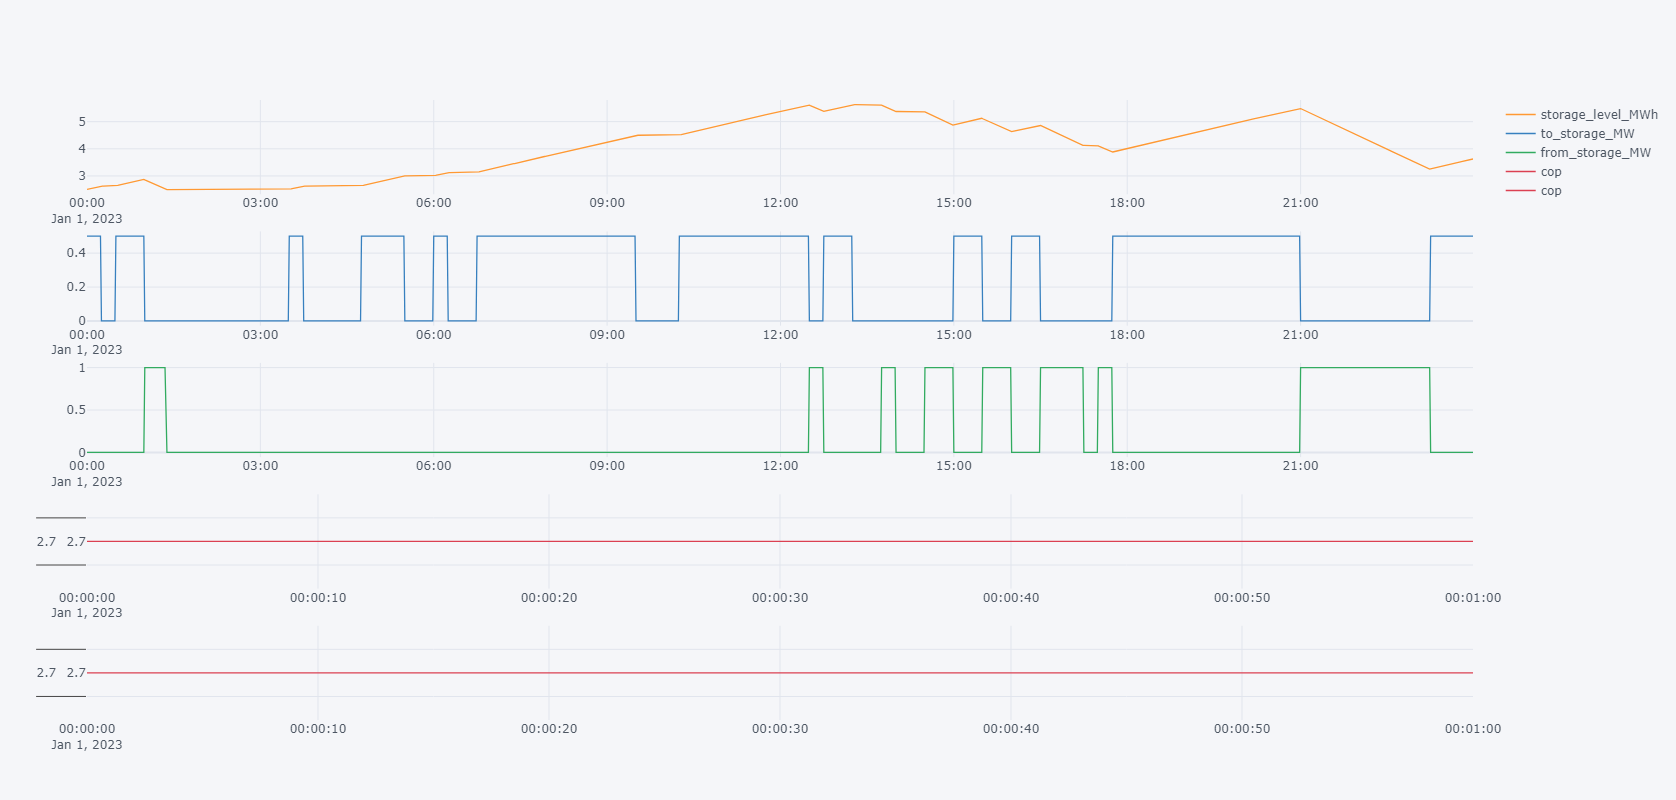

In [77]:
vis_data.loc['2023-01-01', :].iplot(subplots=True, shape=(5,1), dimensions=(1000, 800))

In [78]:
total_to_storage = s.storage_case_PCM.data['to_storage_MWh'].sum()
total_from_storage = s.storage_case_PCM.data['from_storage_MWh'].sum()
total_to_storage, total_from_storage

(180.12000000000003, 1841.7200000000007)

In [79]:
s.storage_case_PCM.data.columns

Index(['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos', 'Gas prices (€/MWh)',
       'CO2 prices (€/ton)', 'CO2 prices (€/MWh)', 'Tsource (VDG)',
       'Tsink (VDG)', 'MW (VDG)', 'Total demand', 'hp_output_MW',
       'hp_input_MW', 'cop', 'tsource_vdg', 'to_storage_vdg_MW',
       'from_storage_vdg_MW', 'to_storage_MW', 'from_storage_MW',
       'storage_level_MWh', 'hp_output_MWh', 'hp_input_MWh',
       'to_storage_vdg_MWh', 'from_storage_vdg_MWh', 'to_storage_MWh',
       'from_storage_MWh'],
      dtype='object')

In [80]:
hp_output = s.storage_case_PCM.data['hp_output_MW'].round(2)
demand_and_to_storage = (s.storage_case_PCM.data['Total demand'] + s.storage_case_PCM.data['to_storage_MW']).round(2)
hp_output.equals(demand_and_to_storage)

True

C:\Users\z004yn8c\AppData\Local\Temp\ipykernel_16932\4223154146.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



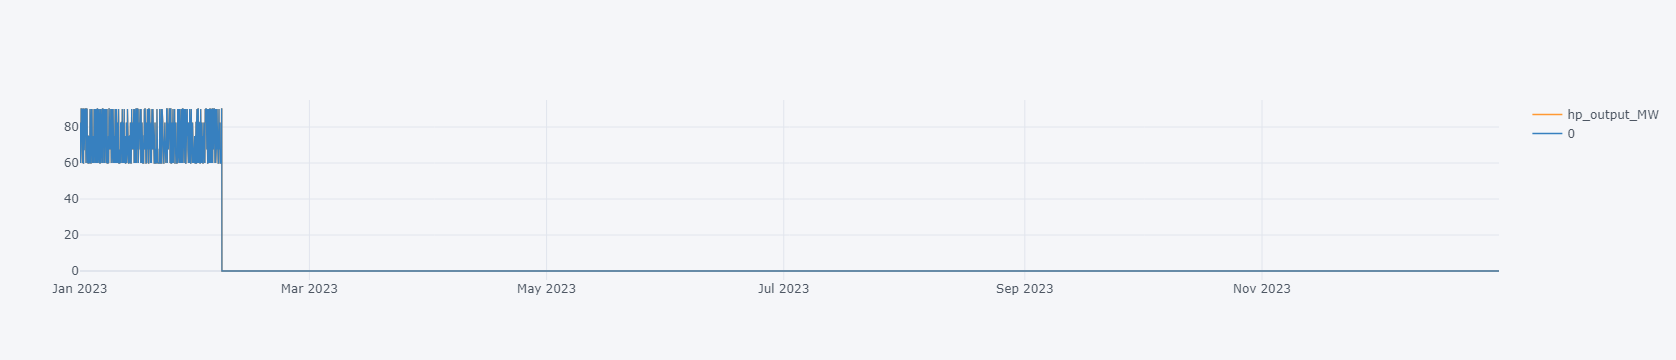

In [81]:
pd.concat([hp_output, demand_and_to_storage], axis=1).resample('H').sum().iplot()

## Financials

In [83]:
def calculate_sde_subsidy(c, s, case):
    hp_capacity = abs(case.assets['Heatpump VDG'].max_th_power) + abs(case.assets['Heatpump NDG'].max_th_power)
    case.full_load_hours = abs(case.data['hp_output_MWh'].sum() / hp_capacity)

    subsidized_hours = min(case.full_load_hours, 8000)
    subsidized_MWh = subsidized_hours * hp_capacity

    base_amount_per_MWh_th = round(c.sde_base_amount*0.173 + c.longterm_gas_price, 2)
    base_subsidy_amount = round(base_amount_per_MWh_th * subsidized_MWh, 2)
    long_term_gas_price_LHV = round(EURperHHV_to_EURperLHV(c.longterm_gas_price), 2)
    base_amount_gas = (2/3)*long_term_gas_price_LHV*0.9
    mean_ttf_price_LHV = round(EURperHHV_to_EURperLHV(case.data['Gas prices (€/MWh)'].mean()), 2)
    correction_amount_gas = max(mean_ttf_price_LHV, base_amount_gas)
    avoided_gas_consumption = subsidized_MWh/0.9
    correction_gas = round(correction_amount_gas * avoided_gas_consumption, 2)

    base_amount_co2 = (2/3)*c.longterm_co2_price
    avoided_co2_emission = avoided_gas_consumption * 0.226
    mean_ets_price = round(EURperHHV_to_EURperLHV(case.data['CO2 prices (€/ton)'].mean()), 2)
    correction_amount_co2 = max(base_amount_co2, mean_ets_price)
    correction_co2 = round(correction_amount_co2 * avoided_co2_emission, 2)

    sde_subsidy_corrected = max(base_subsidy_amount - (correction_gas + correction_co2), 0)
    sde_per_MWh_th = sde_subsidy_corrected / subsidized_MWh
    sde_per_MWh_e = sde_subsidy_corrected / case.data['hp_input_MWh'].abs().sum()

    case.sde_results = {
        'base_amount': base_subsidy_amount,
        'correction_gas': correction_gas,
        'correction_co2': correction_co2,
        'corrected_amount': sde_subsidy_corrected,
        'sde_per_MWh_th': sde_per_MWh_th,
        'sde_per_MWh_e': sde_per_MWh_e
    }
    return case

In [84]:
s.storage_case_PCM.data.columns

Index(['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos', 'Gas prices (€/MWh)',
       'CO2 prices (€/ton)', 'CO2 prices (€/MWh)', 'Tsource (VDG)',
       'Tsink (VDG)', 'MW (VDG)', 'Total demand', 'hp_output_MW',
       'hp_input_MW', 'cop', 'tsource_vdg', 'to_storage_vdg_MW',
       'from_storage_vdg_MW', 'to_storage_MW', 'from_storage_MW',
       'storage_level_MWh', 'hp_output_MWh', 'hp_input_MWh',
       'to_storage_vdg_MWh', 'from_storage_vdg_MWh', 'to_storage_MWh',
       'from_storage_MWh'],
      dtype='object')

In [85]:
def collect_cashflows(c, s):
    s.hpcase.generate_electr_market_results(nom_col='hp_input_MWh', real_col='hp_input_MWh')
    s.storage_case_PCM.data['nomination_MWh'] = s.hpcase.data['hp_input_MWh']
    s.storage_case_PCM.generate_electr_market_results(nom_col='nomination_MWh', real_col='hp_input_MWh')

#    s.hpcase_sde.generate_electr_market_results(nom_col='hp_input_MWh', real_col='hp_input_MWh')
    
#     s.optcase1.data['DA Nom'] = s.hpcase.data['hp_input_MWh'] * c.day_ahead_buying_perc
#     s.optcase1.generate_electr_market_results(nom_col='DA Nom', real_col='hp_input_MWh')
    
#     s.afrr_case.data['POS'] = s.afrr_case.data['aFRR_up'].fillna(value=s.afrr_case.data['POS'])
#     s.afrr_case.data['DA Nom'] = s.hpcase.data['hp_input_MWh']
#     s.afrr_case.generate_electr_market_results(nom_col='DA Nom', real_col='hp_input_MWh')
#     s.afrr_case.add_cashflow('aFRR capacity fee (€)', c.afrr_capacity_fee * s.afrr_case.afrr_capacity)
    
    for case in [s.baseline]: #, s.optcase1, s.afrr_case]:
        case.add_gas_costs(gasvolumes_col='gb_input_MWh')
        case.add_co2_costs(volume_cols='gb_input_MWh', fuel='gas')
        case.add_eb_ode(commodity='gas', tax_bracket=c.tax_bracket_g)
        
    for case in [s.hpcase, s.storage_case_PCM]: #, s.hpcase_sde, s.optcase1, s.afrr_case]:
        
        case.add_eb_ode(commodity='electricity', tax_bracket=c.tax_bracket_e, cons_col='hp_input_MWh')
        case.add_grid_costs(
            power_MW_col='hp_input_MW',
            grid_operator=c.grid_operator,
            year=2020, 
            connection_type=c.connection_type
        )
        
    for case in s.sde_cases:
        case = calculate_sde_subsidy(c=c, s=s, case=case)
        case.add_cashflow('SDE++ subsidy (€)', case.sde_results['corrected_amount'])
    return s

s = collect_cashflows(c, s)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:369: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:372: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:369: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:372: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [86]:
def calculate_financials(c, s):
    for case in s.cases:
        case.calculate_ebitda(c.project_duration)

    for case in [s.hpcase, s.storage_case_PCM]: #, s.hpcase_sde, s.optcase1, s.afrr_case]:
        case.calculate_business_case(
            project_duration=c.project_duration, 
            discount_rate=c.discount_rate, 
            baseline=s.baseline
        )
        
    return s

s = calculate_financials(c, s)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:403: UserWarning:

Cashflow 'Grid transport costs (€)' for CaseStudy 'Heatpump only' contains NaN value. Something might have gone wrong. Replacing NaN with 0 for now.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:403: UserWarning:

Cashflow 'Grid transport costs (€)' for CaseStudy 'Heatpump + Storage_PCM' contains NaN value. Something might have gone wrong. Replacing NaN with 0 for now.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\financial.py:540: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\Gi

## Visualisations

C:\Users\z004yn8c\AppData\Local\Temp\ipykernel_16932\1396106630.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\z004yn8c\AppData\Local\anaconda3\Lib\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



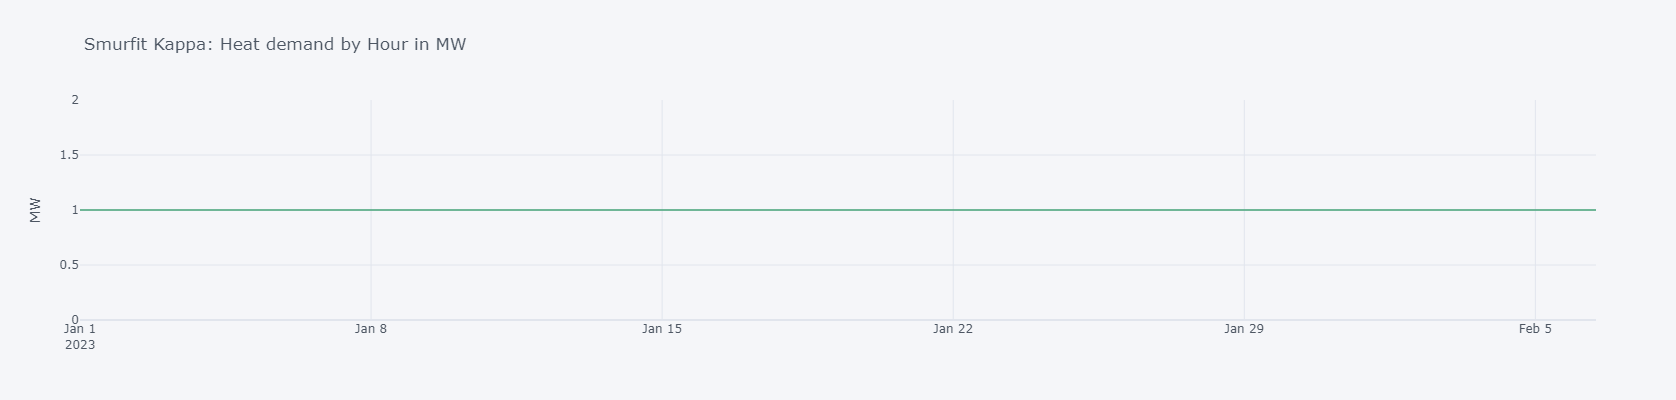

In [88]:
fig_demands_over_time = s.demand['Total demand'].resample('H').mean().iplot(
    title='Smurfit Kappa: Heat demand by Hour in MW', 
    yTitle='MW', 
    colors=recoygreen,
    asFigure=True,
    dimensions=(800, 400)
)
fig_demands_over_time

C:\Users\z004yn8c\AppData\Local\Temp\ipykernel_16932\1493830805.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



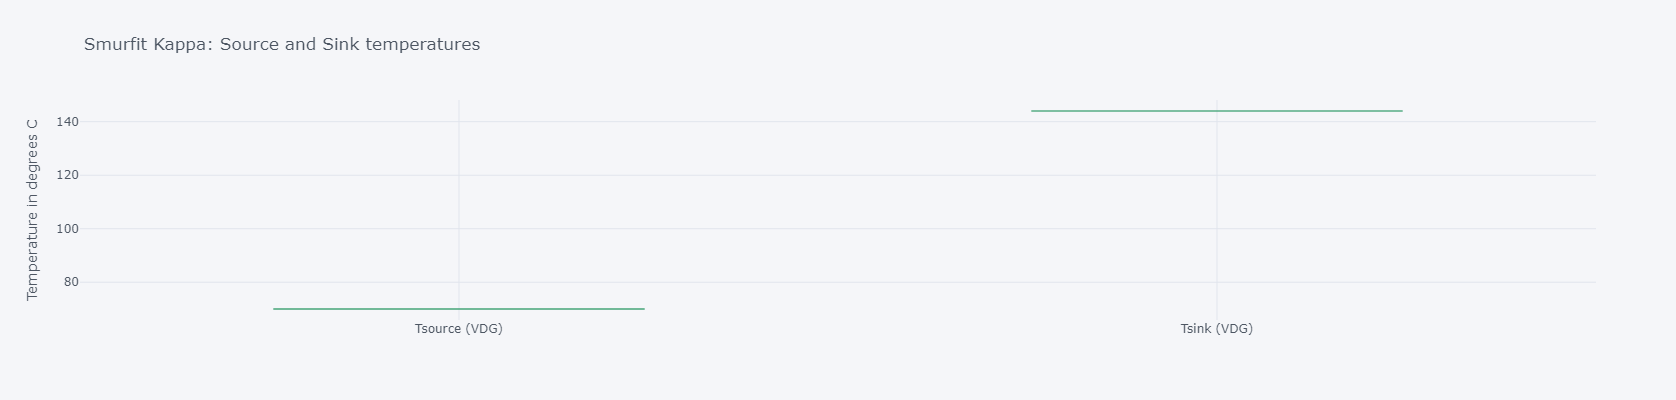

In [89]:
demands_fig = s.demand[['Tsource (VDG)', 'Tsink (VDG)']].resample('H').mean().iplot(
    kind='box',
    title='Smurfit Kappa: Source and Sink temperatures',
    color=recoygreen,
    yTitle='Temperature in degrees C',
    legend=False,
    asFigure=True,
    dimensions=(800, 400)
)
demands_fig

In [90]:
s.storage_case_PCM.data.columns

Index(['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos', 'Gas prices (€/MWh)',
       'CO2 prices (€/ton)', 'CO2 prices (€/MWh)', 'Tsource (VDG)',
       'Tsink (VDG)', 'MW (VDG)', 'Total demand', 'hp_output_MW',
       'hp_input_MW', 'cop', 'tsource_vdg', 'to_storage_vdg_MW',
       'from_storage_vdg_MW', 'to_storage_MW', 'from_storage_MW',
       'storage_level_MWh', 'hp_output_MWh', 'hp_input_MWh',
       'to_storage_vdg_MWh', 'from_storage_vdg_MWh', 'to_storage_MWh',
       'from_storage_MWh', 'nomination_MWh', 'Prod. vol.', 'Cons. vol.',
       'Imb. vol.', 'Day-Ahead Result', 'POS Result', 'NEG Result',
       'Imbalance Result', 'Combined Result'],
      dtype='object')

In [91]:
# temp_comparison = pd.concat([s.storage_case_PCM.data[['tsource_ndg', 'tsource_vdg']], s.storage_case_PCM.data[['Tsource (NDG)', 'Tsource (VDG)']]], axis=1)
# temp_comparison.columns = ['Tsource (NDG) -after', 'Tsource (VDG) - after', 'Tsource (NDG) - before', 'Tsource (VDG) - before']
# temp_comparison.resample('15T').mean().iplot()

In [92]:
s.storage_case_PCM.data['tsource_vdg'].idxmin()

Timestamp('2023-01-01 00:00:00+0100', tz='Europe/Amsterdam')

In [93]:
# s.storage_case_PCM.data.loc['2019-01-04 07:45:00']

In [94]:
case = s.storage_case_PCM
hp_vdg = case.assets['Heatpump VDG']
ws = case.assets['HotWaterStorage']
ws.storage_level = 47.083 + 25
pos = 35.650
neg = 43.850
dam = 68.400
demand_vdg = 0
tsource_vdg = 29.635
tsink_vdg = 134.840

hp_storage_opt_enginge(c, ws, hp_vdg, pos, neg, dam, demand_vdg, tsource_vdg, tsink_vdg)

(0,
 0,
 29.635,
 0,
 0,
 HotWaterStorage(name=HotWaterStorage, rated_power=25, capacity=50.0, temperature=95, min_storagelevel=2.5),
 Heatpump(name='Heatpump VDG', max_thermal_power=23.3, cop_curve=2.7, min_th_power=0.0))

In [95]:
#e_load_vdg, th_load_vdg, e_load_ndg, th_load_ndg, tsource_vdg, tsource_ndg, to_storage_vdg_MW, from_storage_vdg_MW, to_storage_ndg_MW, from_storage_ndg_MW, ws, hp_vdg, hp_ndg

In [96]:
Tsource_VDG_before = s.hpcase.data['Tsource (VDG)'].round(2)
Tsource_VDG_after = s.storage_case_PCM.data['Tsource (VDG)'].round(2)
Tsource_VDG_before.equals(Tsource_VDG_after)

True

In [97]:
test_hp = Heatpump(
    name='Heatpump for Testing',
    max_th_power=1,
    min_th_power=0.3,
    cop_curve=cop_curve
)

In [98]:
# Tsrc_vdg, Tsnk_vdg, Tsrc_ndg, Tsnk_ndg = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].mean().to_list()
# mean_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].mean() 
#              + s.eb_ode_g 
#              + s.optcase1.data['CO2 prices (€/MWh)'].mean()
#             )

# max_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].max() 
#              + s.eb_ode_g 
#              + s.optcase1.data['CO2 prices (€/MWh)'].max()
#             )

# min_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].min() 
#              + s.eb_ode_g 
#              + s.optcase1.data['CO2 prices (€/MWh)'].min()
#             )

# Tsrc_vdg_min, Tsnk_vdg_min, Tsrc_ndg_min, Tsnk_ndg_min = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].min().to_list()
# Tsrc_vdg_max, Tsnk_vdg_max, Tsrc_ndg_max, Tsnk_ndg_max = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].max().to_list()

In [99]:
import plotly.graph_objs as go
def create_load_trace(gas_price, Tsnk, Tsrc, name):
    loads = []
    eprices = list(range(1000))
    for eprice in eprices:
        _, load = test_hp.set_opt_load(
            electricity_cost=eprice + s.eb_ode_e,
            alt_heat_price=gas_price / 0.9,
            demand=1, 
            Tsink=Tsnk,
            Tsource=Tsrc
        )
        loads.append(load)
    trace = go.Scatter(x=eprices, y=loads, name=name)
    return trace

In [100]:
# import plotly.graph_objects as go
# import numpy as np

# fig = go.Figure()

# configs = {
#     'mean': [mean_gas_price, Tsnk_vdg, Tsrc_vdg],
#     'unfav_gas': [min_gas_price, Tsnk_vdg, Tsrc_vdg],
#     'fav_gas': [max_gas_price, Tsnk_vdg, Tsrc_vdg],
#     'unfav_all': [min_gas_price, Tsnk_vdg_max, Tsrc_vdg_min],
#     'fav_all': [max_gas_price, Tsnk_vdg_min, Tsrc_vdg_max],
# }

# for name, config in configs.items():
#     trace = create_load_trace(*config, name)
#     fig.add_trace(trace)

# fig.update_layout(title='Switch prices for different configurations')
# fig.show()

In [101]:
date = s.baseline.data.index[0].strftime('%Y-%m-%d')

C:\Users\z004yn8c\AppData\Local\anaconda3\Lib\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



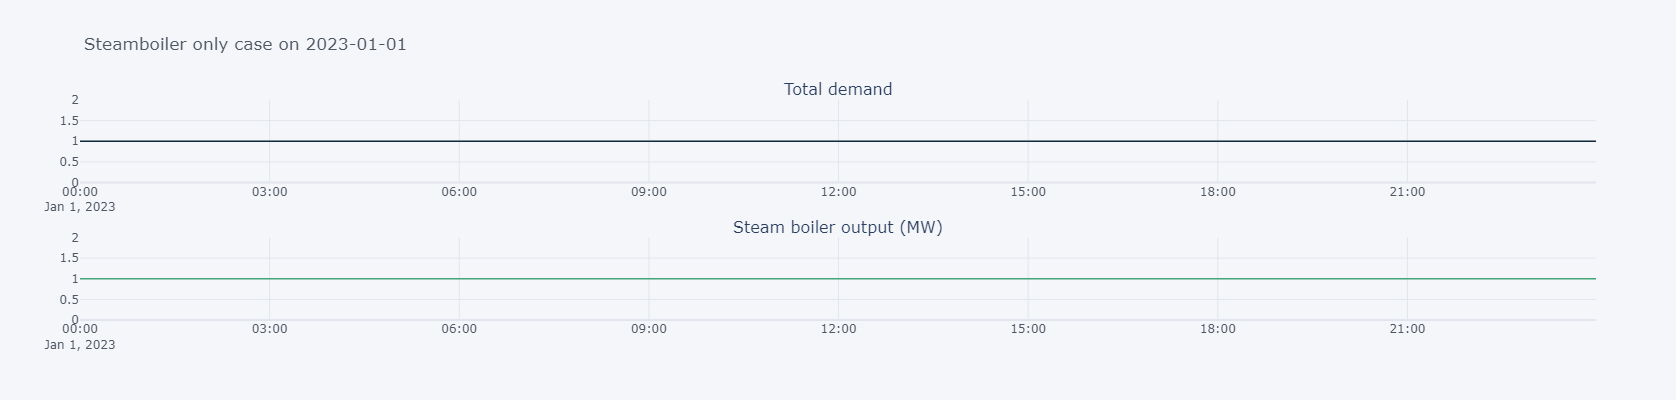

In [102]:
fig_steamboiler = s.baseline.data[['Total demand', 'output_MW_th']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Steamboiler only case on {date}',
    subplot_titles=['Total demand', 'Steam boiler output (MW)'],
    legend=False,
    dimensions=(800, 400),
    colors=[recoydarkblue, recoygreen], 
    asFigure=True,
    shape = (2, 1)
)
fig_steamboiler

C:\Users\z004yn8c\AppData\Local\anaconda3\Lib\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



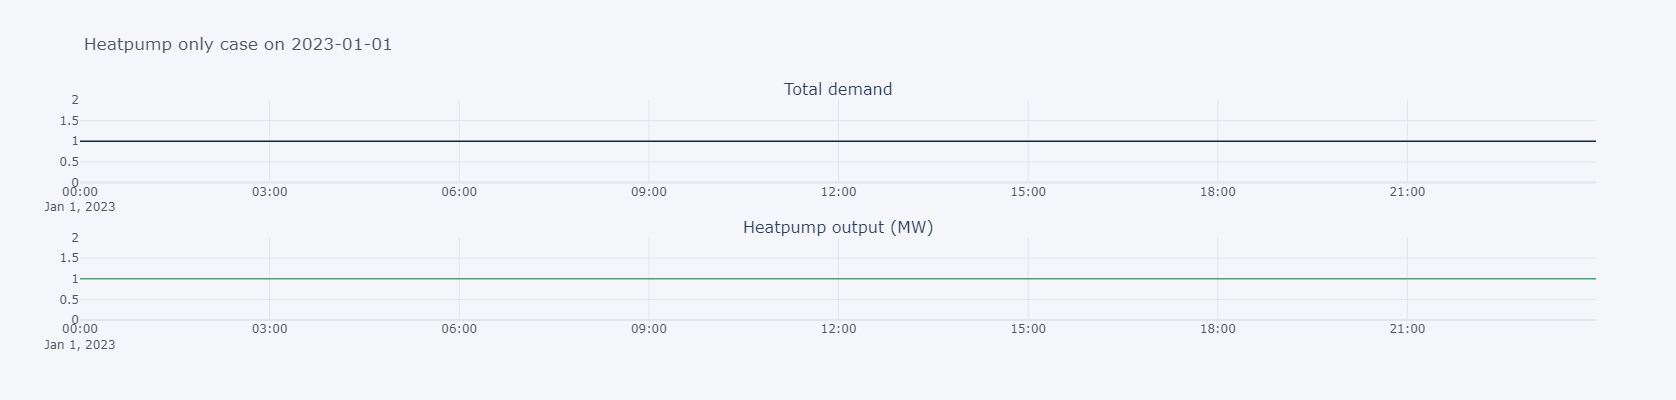

In [103]:
fig_heatpump = s.hpcase.data[['Total demand', 'hp_output_MW']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Heatpump only case on {date}', 
    subplot_titles=['Total demand', 'Heatpump output (MW)'],
    legend=False,
    dimensions=(800, 400),
    colors=[recoydarkblue, recoygreen], 
    asFigure=True,
    shape = (2, 1)
)
fig_heatpump

In [104]:
# fig_optcase = s.optcase1.data[['hp_output_MW', 'gb_output_MW', 'NEG']].loc[date, :].iplot(
#     subplots=True, 
#     title=f'Hybrid case on {date}',
#     subplot_titles=['Heatpump output (MW)', 'Steam boiler output (MW)', 'Imbalance price (€/MWh)'],
#     legend=False,
#     dimensions=(800, 600),
#     colors=[recoydarkblue, recoygreen, recoyred],
#     asFigure=True,
#     shape=(3,1)
# )
# fig_optcase

In [105]:
# date = '2019-09-04'

# fig_optcase2 = s.optcase1.data[['hp_output_MW', 'gb_output_MW', 'NEG']].loc[date, :].iplot(
#     subplots=True, 
#     title=f'Hybrid case on {date}',
#     subplot_titles=['Heatpump output (MW)', 'Steam boiler output (MW)', 'Imbalance price (€/MWh)'],
#     legend=False,
#     dimensions=(800, 600),
#     colors=[recoydarkblue, recoygreen, recoyred],
#     asFigure=True,
#     shape=(3,1)
# )
# fig_optcase2

In [106]:
report = ComparisonReport(
    cases=s.optcases, 
    kind='electr_market_results',
)
report.show()

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\reports.py:46: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Heatpump only Heatpump + Storage_PCM
Total net volume (MWh)                   -315                   -383
Total exported to grid (MWh)                -                      -
Total consumed from grid (MWh)            315                    383
Total nominated volume (MWh)             -315                   -315
Absolute imbalance volume (MWh)             -                     68
Mean selling price (€/MWh)                  -                      -
Mean buying price (€/MWh)                 128                    112
Total day-ahead result (€)            -40,253                -40,253
Total POS result (€)                        -                      -
Total NEG result (€)                        -                 -2,609
Total imbalance result (€)                  -                 -2,609
Total combined result (€)             -40,253                -42,862

In [107]:
casereport = ComparisonReport(cases = s.cases, kind='ebitda_calc', baseline=s.baseline, comparison='relative')
casereport.show(presentation_format=True)

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\reports.py:46: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Heatpump only Heatpump + Storage_PCM
Gasboiler OPEX (€)                           -                      -
Gas consumption costs (€)               59,959                 59,959
CO2 emission costs (€)                     989                    989
Gas taxes (€)                            3,369                  3,369
Heatpump VDG OPEX (€)                  -46,600                -46,600
Result on electricity market (€)       -40,253                -42,862
Electricity taxes (€)                     -300                   -364
Grid transport costs (€)                     -                      -
HotWaterStorage OPEX (€)                     -                 -8,500
EBITDA (€)                             -22,835                -34,009
Depreciation (€)                      -186,400               -203,400
EBITDA + depr (€)                     -209,235               -237,409

In [108]:
BusinessCaseReport(s.hpcase).show()

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\styling.py:42: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Year 0    Year 1    Year 2    Year 3  \
CAPEX (€)                      -4,683,300                                 
Regular Earnings (€)                        -22,835   -22,835   -22,835   
Irregular Cashflows (€)                           -         -         -   
EBITDA (€)                                  -22,835   -22,835   -22,835   
Depreciations (€) -/-                      -186,400  -186,400  -186,400   
EBIT (€)                                   -209,235  -209,235  -209,235   
Income tax (Vpb.) (€)                             -         -         -   
NOPLAT (€)                                 -209,235  -209,235  -209,235   
Depreciations (€) +/+                       186,400   186,400   186,400   
Free Cash Flow (€)             -4,683,300   -22,835   -22,835   -22,835   
Simple Payback Period                 N/A                                 
IRR (%)                               N/A                                 
WACC (%)                              10%                                 
NPV of explicit period (€)     -4,398,994                                 
Discounted residual value (€)     779,530                                 
NPV (€)                        -4,398,994                                 

                                 Year 4    Year 5    Year 6    Year 7  \
CAPEX (€)                                                               
Regular Earnings (€)            -22,835   -22,835   -22,835   -22,835   
Irregular Cashflows (€)               -         -         -         -   
EBITDA (€)                      -22,835   -22,835   -22,835   -22,835   
Depreciations (€) -/-          -186,400  -186,400  -186,400  -186,400   
EBIT (€)                       -209,235  -209,235  -209,235  -209,235   
Income tax (Vpb.) (€)                 -         -         -         -   
NOPLAT (€)                     -209,235  -209,235  -209,235  -209,235   
Depreciations (€) +/+           186,400   186,400   186,400   186,400   
Free Cash Flow (€)              -22,835   -22,835   -22,835   -22,835   
Simple Payback Period                                                   
IRR (%)                                                                 
WACC (%)                                                                
NPV of explicit period (€)                                              
Discounted residual value (€)                                           
NPV (€)                                                                 

                                 Year 8    Year 9   Year 10   Year 11  \
CAPEX (€)                                                               
Regular Earnings (€)            -22,835   -22,835   -22,835   -22,835   
Irregular Cashflows (€)               -         -         -         -   
EBITDA (€)                      -22,835   -22,835   -22,835   -22,835   
Depreciations (€) -/-          -186,400  -186,400  -186,400  -186,400   
EBIT (€)                       -209,235  -209,235  -209,235  -209,235   
Income tax (Vpb.) (€)                 -         -         -         -   
NOPLAT (€)                     -209,235  -209,235  -209,235  -209,235   
Depreciations (€) +/+           186,400   186,400   186,400   186,400   
Free Cash Flow (€)              -22,835   -22,835   -22,835   -22,835   
Simple Payback Period                                                   
IRR (%)                                                                 
WACC (%)                                                                
NPV of explicit period (€)                                              
Discounted residual value (€)                                           
NPV (€)                                                                 

                                Year 12  
CAPEX (€)                                
Regular Earnings (€)            -22,835  
Irregular Cashflows (€)               -  
EBITDA (€)                      -22,835  
Depreciations (€) -/-          -186,400  
EBIT (€)               

C:\Users\z004yn8c\AppData\Local\anaconda3\Lib\site-packages\cufflinks\plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



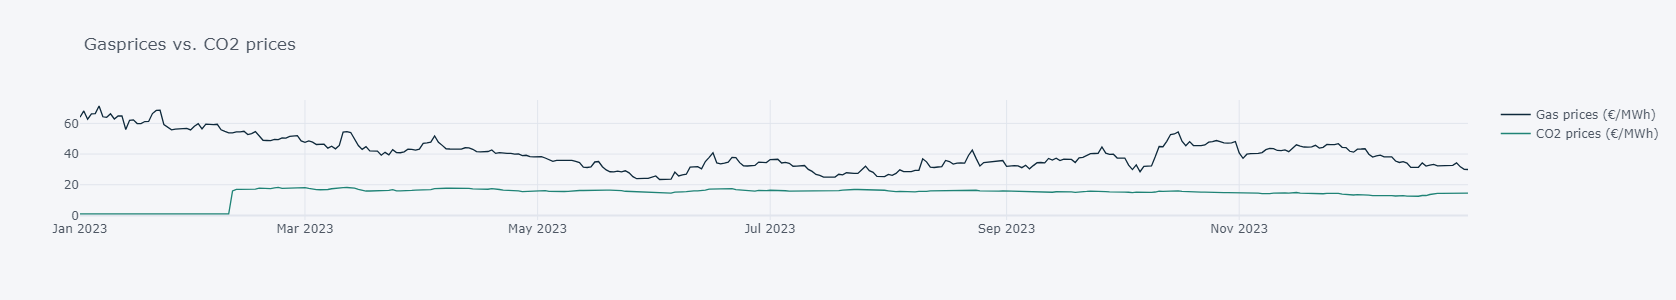

In [109]:
#price chart
from copy import deepcopy

data = deepcopy(s.baseline.data)
data = data[data.columns[:2]]
data[data.columns[1]] = MWh_gas_to_tonnes_CO2(data[data.columns[1]])
data = data.rename(columns={"CO2 prices (€/ton)": "CO2 prices (€/MWh)"})

data.resample('D').mean().iplot(dimensions=(800, 300), title='Gasprices vs. CO2 prices', colors=recoycolors)

In [110]:
# #price chart
# from copy import deepcopy

# s.optcase1.data['DAM'].resample('D').mean().iplot(dimensions=(800, 300), title='Electricity Prices', colors=recoycolors)

# _source_output = s.optcase1.data[['hp_output_MWh', 'gb_output_MWh']].resample('M').sum()
# _total_output = _source_output.sum(axis=1)
# _data = _source_output.divide(_total_output, axis=0).rename(
#     columns={'hp_output_MWh':'Heat pump', 'gb_output_MWh':'Gasboiler'}
# ) * 100

# production_fig = _data.iplot(
#     kind='bar',
#     barmode='stack',
#     colors=[recoydarkblue, recoygreen],
#     title='Hybrid case: Heat production per Month by Source in % share',
#     yTitle='Share of production in %',
#     dimensions=(600, 400),
#     asFigure=True
# )

# production_fig = production_fig.update_layout(legend_traceorder="reversed")
# production_fig

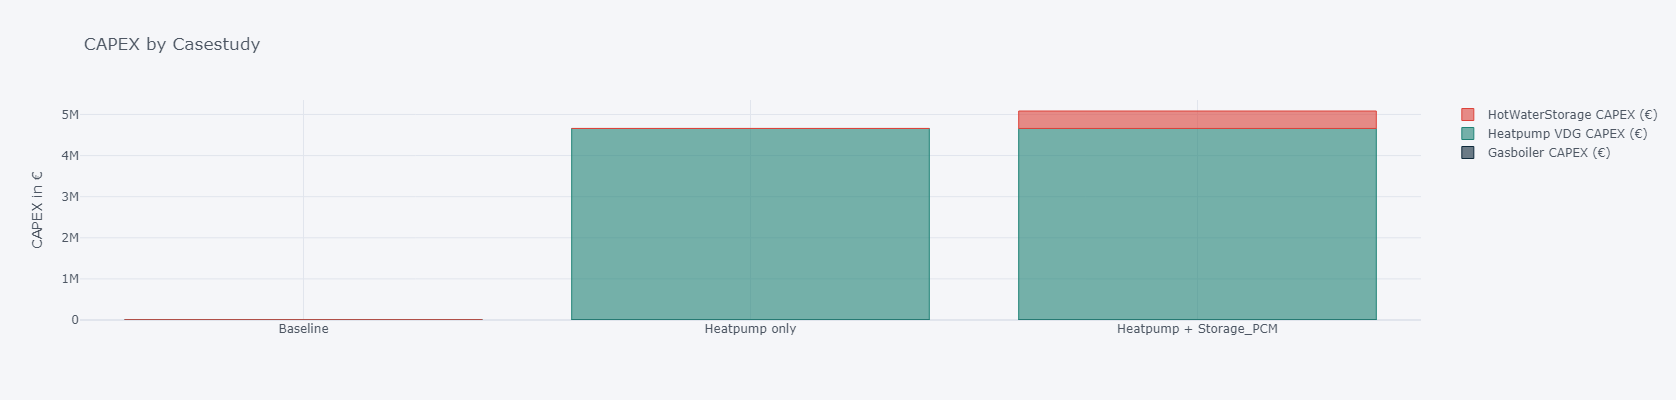

In [111]:
report = ComparisonReport(s.cases, kind='capex').report
report = report[report.index.str.contains('CAPEX')].T
capex_fig = report.iplot(
    kind='bar', 
    barmode='relative',
    colors=recoycolors,
    title='CAPEX by Casestudy',
    yTitle='CAPEX in €',
    dimensions=(600, 400),
    asFigure=True,
)

capex_fig = capex_fig.update_layout(legend_traceorder="reversed")
capex_fig

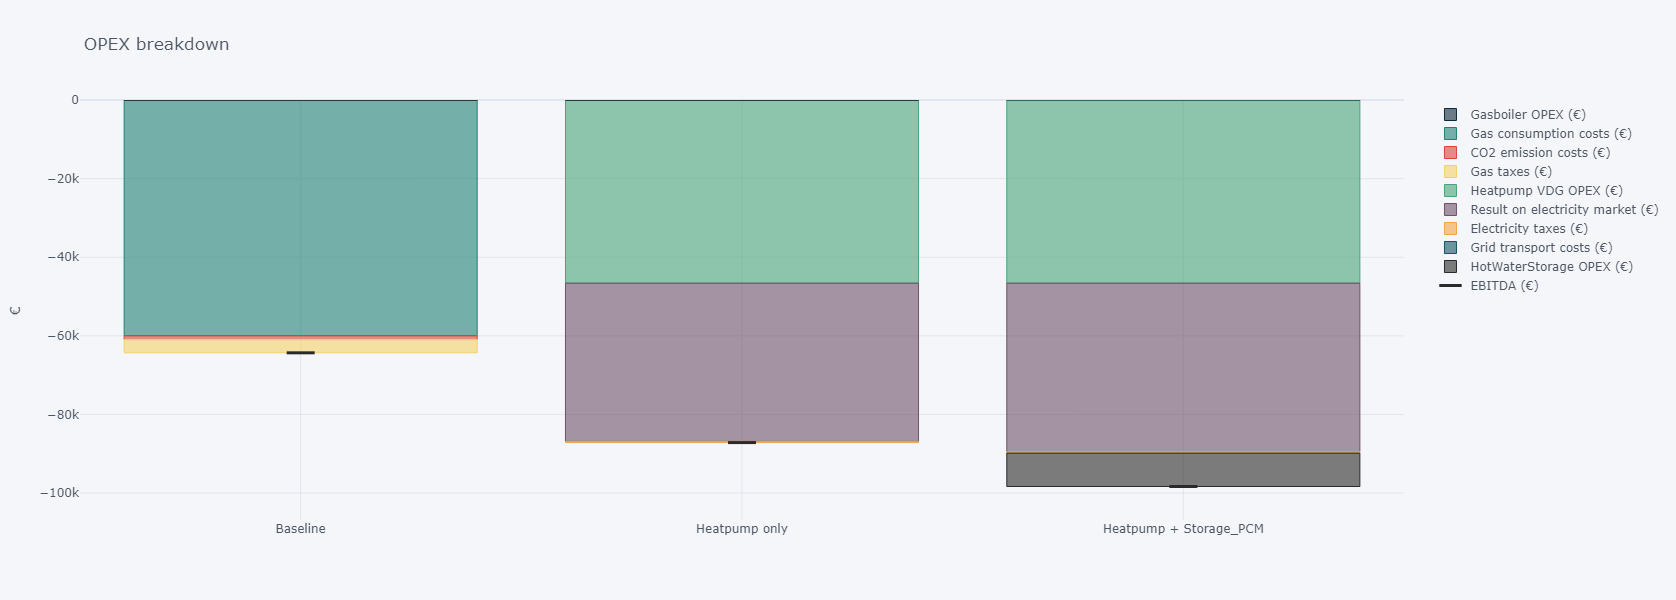

In [112]:
cashflow_report = ComparisonReport(cases = s.cases, kind='cashflows')

fig = cashflow_report.report.T.iplot(
    kind='bar',
    barmode='relative',
    colors=recoycolors,
    title='OPEX breakdown',
    asFigure=True,
    yTitle='€',
    dimensions=(800, 600)
)

ebitda_report = ComparisonReport(cases=s.cases, kind='ebitda_calc')
scat = go.Scatter(
    mode='markers',
    y=ebitda_report.report.loc['EBITDA (€)', :].values, 
    x=ebitda_report.report.columns, 
    line=go.scatter.Line(color=recoydarkgrey),
    marker=dict(
        color=recoydarkgrey,
        size=20,
        line=dict(
            color=recoydarkgrey,
            width=3
        ),
        symbol='line-ew'
    ),
    name='EBITDA (€)'
)
fig.add_trace(scat)
fig

In [113]:
# ebitda_report.show(comparison='relative')

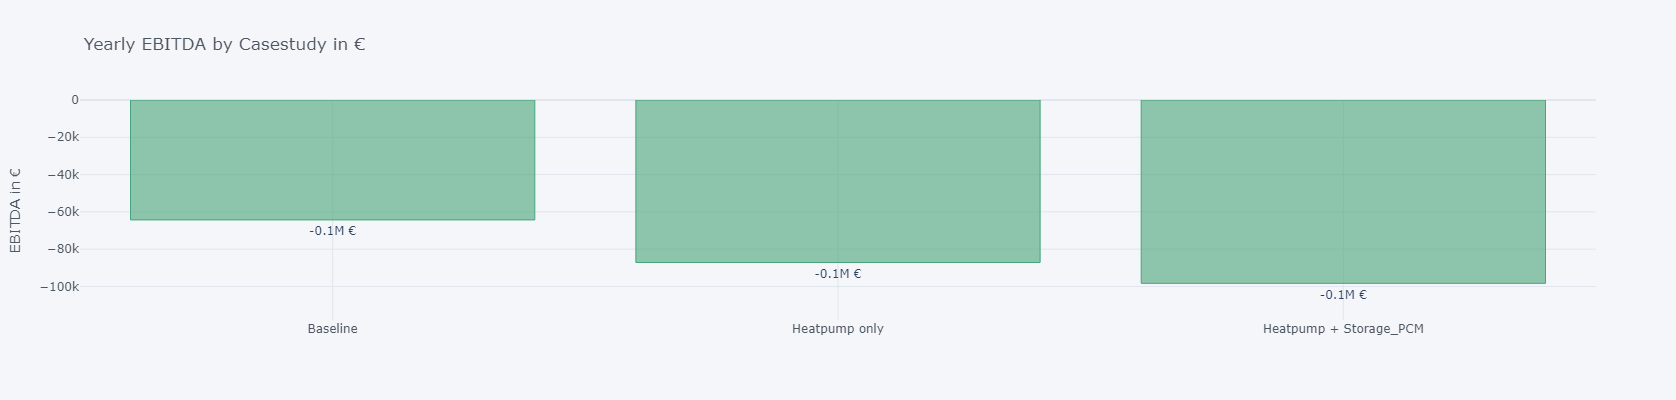

In [114]:
_series = SingleFigureComparison(s.cases, 'ebitda', label='EBITDA').report
ebitda_graph = _series.iplot(
    kind='bar',
    title='Yearly EBITDA by Casestudy in €',
    colors=recoygreen,
    dimensions=(600, 400), 
    yTitle='EBITDA in €',
    asFigure=True,
    yrange=[_series.min() * 1.2, max(_series.max() * 2, 0)]
)

ebitda_graph.update_traces(
    text=_series.values/1000_000, 
    textposition='outside', 
    texttemplate="%{text:.1f}M €", 
)

ebitda_graph

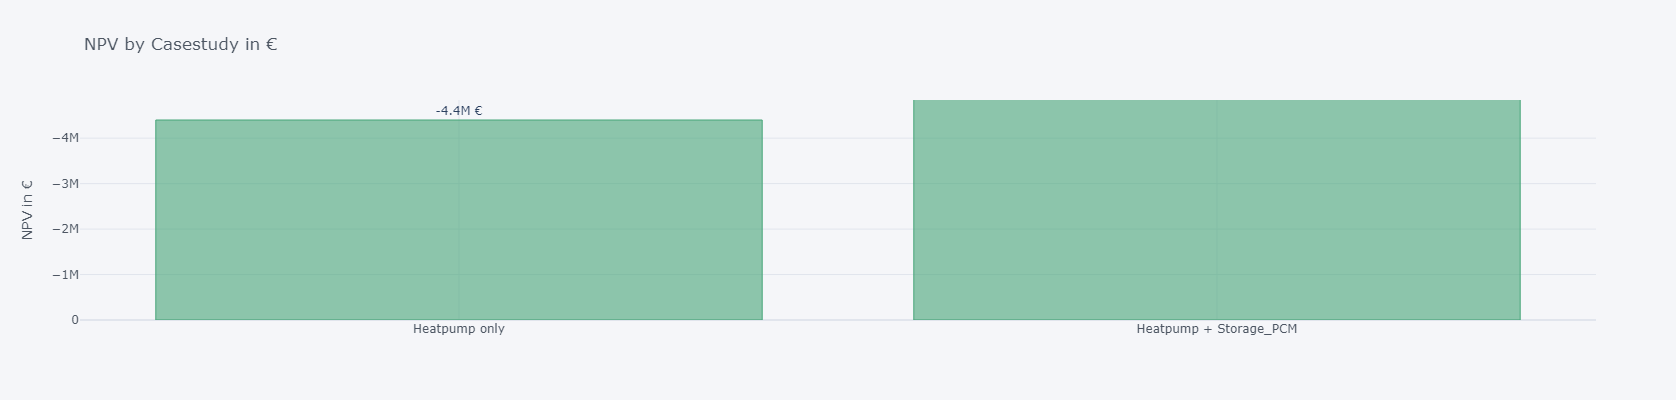

In [115]:
_series = SingleFigureComparison(s.optcases, 'npv', label='NPV').report

npv_graph = _series.iplot(
    kind='bar',
    title='NPV by Casestudy in €',
    colors=recoygreen,
    dimensions=(600, 400), 
    yTitle='NPV in €',
    asFigure=True,
    yrange=[0, _series.max() * 1.1]
)

npv_graph.update_traces(
    text=_series.values/1000_000, 
    textposition='outside', 
    texttemplate="%{text:.1f}M €", 
)

npv_graph

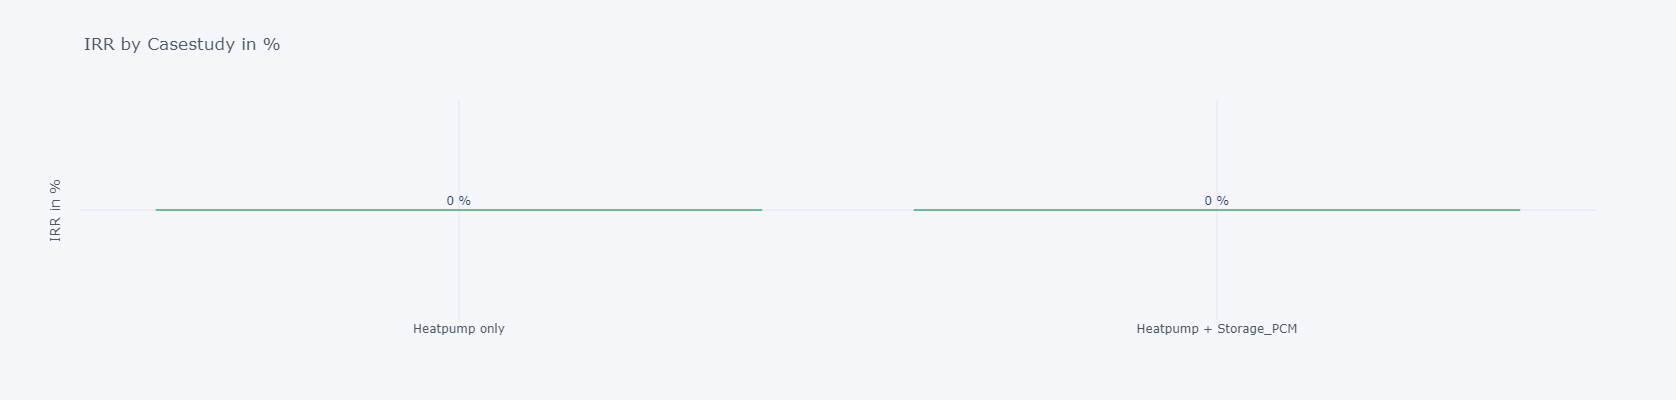

In [116]:
irr_report = (SingleFigureComparison(s.optcases, 'irr', label='IRR').report * 100)
irr_fig = irr_report.iplot(
    kind='bar',
    title='IRR by Casestudy in %',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='IRR in %',
    asFigure=True,
    yrange=[0, irr_report.max() * 1.2]
)

irr_fig.update_traces(
    text=irr_report.values, 
    textposition='outside', 
    texttemplate="%{text:.0f} %", 
)

irr_fig

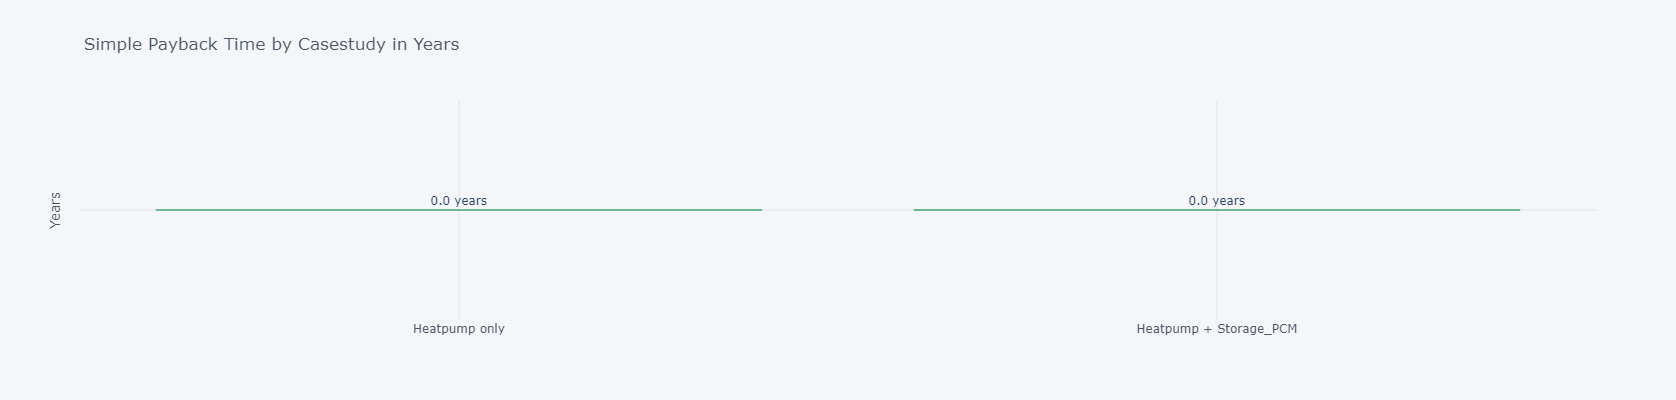

In [117]:
_series = (SingleFigureComparison(s.optcases, 'spp', label='Simple Payback Time').report)
spt_fig = _series.iplot(
    kind='bar',
    title='Simple Payback Time by Casestudy in Years',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='Years',
    asFigure=True,
    yrange=[0, _series.max() * 1.2]
)

spt_fig.update_traces(
    text=_series.values, 
    textposition='outside', 
    texttemplate="%{text:.1f} years", 
)

spt_fig 

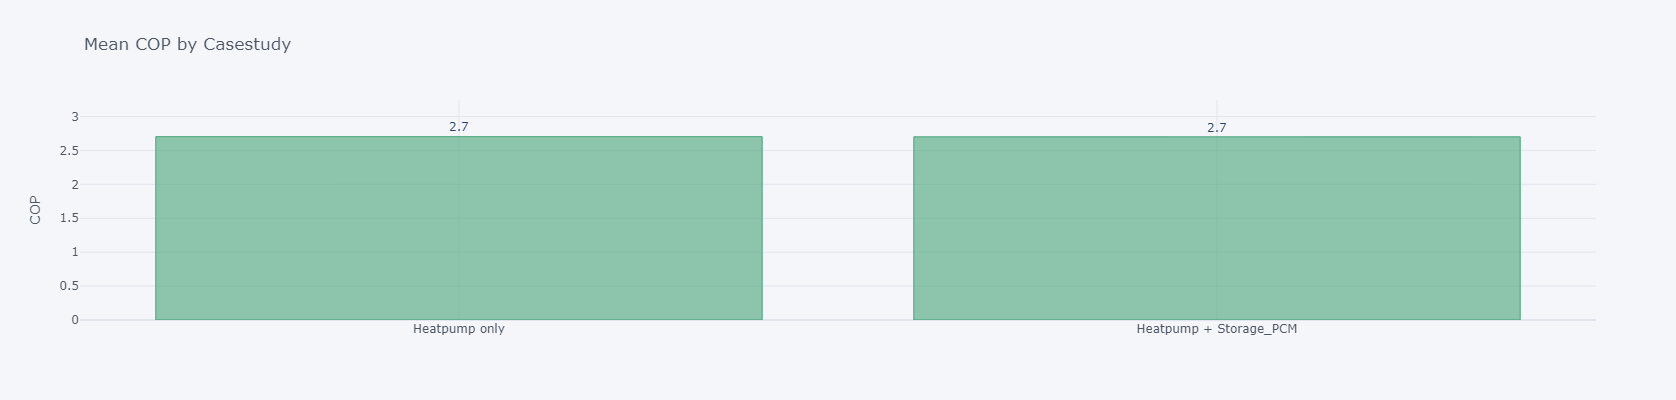

In [118]:
mean_cops = (SingleFigureComparison(s.optcases, 'mean_cop', label='COP').report)
cop_fig = mean_cops.iplot(
    kind='bar',
    title='Mean COP by Casestudy',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='COP',
    asFigure=True,
    yrange=[0, mean_cops.max() * 1.2]
)

cop_fig.update_traces(
    text=mean_cops.values, 
    textposition='outside', 
    texttemplate="%{text:.1f}", 
)

cop_fig 

## Sensitivity analysis

We have agreed that for the sensitivity analysis we will vary the following key assumptions in the flex-model:
1. Market prices of gas and electricity. We will use the actual prices for 2019, the actual prices for 2020.
2. aFRR prices +/- 30%
3. CAPEX
4. CO2 price
5. Tsource +/- 10 degrees Celsius
6. Tsink
    * Roam off the peak / lower pressure
    * Stabalize / running average per hour/ 2 hours
7. __A scenario with a constraint on grid capacity and a scenario without grid capacity as a constraint__
8. Energy Tax and ODE +/- 30%

In [121]:
def setup():
    _c = Config()
    s = setup_model(c=_c)
    return s

def routine(c, s):
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    #s = preprocessing(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    #s = postprocessing(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [122]:
%time _s = setup()

testetss


C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:41: UserWarning:

The chosen timeperiod spans 365.99930555555557 days, which is not a full year. Beware that certain functions that use yearly rates might return incorrect values.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\forecasts.py:62: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



CPU times: total: 6.28 s
Wall time: 18 s


C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\forecasts.py:115: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:54: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:54: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\framework.py:54: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\AppData\Local\Temp\ipykernel_16932\1095823442.py:3: FutureWarning:

'T' is deprecated and will be removed in a future

In [123]:
%time result = routine(c, _s)
npv = result.hpcase.npv
npv

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecate

CPU times: total: 5.28 s
Wall time: 10.8 s


C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:369: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:372: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:369: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:372: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\casestudy.py:403: UserWarning:

Cashf

-4398993.877691695

In [124]:
# sensitivity:Storage temperature
values = range(80, 120, 10)
param = 'storage_temperature'
kpis = ['npv','irr','spp', 'mean_cop']

sens = SensitivityAnalysis(c, _s, routine, param, values, kpis)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:443: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\z004yn8c\OneDrive - Siemens AG\Documents\GitHub\Mooi-Kickstart\pyrecoy\pyrecoy\pyrecoy2\prices.py:531: FutureWarning:

'T' is deprecate

AttributeError: 'DataFrame' object has no attribute 'to_list'

In [ ]:
output = sens.single_kpi_overview('npv', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='volume(m3)',
    yTitle='NPV in €',
    yrange=[output.min().min()*1.1, 0],
    title='Sensitivity: Storage volume',
    colors=recoycolors,
    dimensions=(600, 400),
)

### Sensitivity: Water storage volume

In [ ]:
(_s.demand['MW (VDG)'] + _s.demand['MW (NDG)']).to_list()[:3]

In [ ]:
%time _s = setup()

In [ ]:
values = range(100, 500, 100)
param = 'storage_volume'
kpis = ['npv','irr','spp']

sens = SensitivityAnalysis(c, _s, routine, param, values, kpis)

In [ ]:
[case.name for case in s.cases][1:]

In [ ]:
output = sens.single_kpi_overview('npv', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='volume(m3)',
    yTitle='NPV in €',
    yrange=[output.min().min()*1.1, 0],
    title='Sensitivity: Storage volume',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('irr', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='volume(m3)',
    yTitle='irr in %',
    yrange=[output.min().min()*1.1, 0],
    title='Sensitivity: IRR',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='volume(m3)',
    yTitle='years',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: payback time',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='volume(m3)',
    yTitle='COP',
    yrange=[output.min().min()*1.1, 0],
    title='Sensitivity: COP',
    colors=recoycolors,
    dimensions=(600, 400),
)

### Sensitivity: CAPEX per MW storage

In [ ]:
values = range(4_000, 10_000, 2_000)
param = 'storage_capex_per_MW'
kpis = ['npv', 'irr', 'spp', 'mean_cop']

sens = SensitivityAnalysis(c, _s, routine, param, values, kpis)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX',
    yTitle='NPV in Euro',
    yrange=[output.min().min()*1.1, 0],
    title='Sensitivity: NPV in euro',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX/MW',
    yTitle='years',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: payback time',
    colors=recoycolors,
    dimensions=(600, 400),
)

### Sensitivity: CAPEX per MWh storage

In [ ]:
values = range(1_000, 5_000, 1000)
param = 'storage_capex_per_MWh'
kpis = ['npv', 'spp', 'mean_cop']

sens = SensitivityAnalysis(c, _s, routine, param, values, kpis)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX/MWh',
    yTitle='NPV',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: NPV in Euro',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX/MWh',
    yTitle='years',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: Payback time',
    colors=recoycolors,
    dimensions=(600, 400),
)

### Sensitivity: threshold price

In [ ]:
values = range(10, 60, 10)
param = 'threshold'
kpis = ['npv', 'spp', 'mean_cop']

sens = SensitivityAnalysis(c, _s, routine, param, values, kpis)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='threshold',
    yTitle='NPV',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: NPV in Euro',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='threshold',
    yTitle='years',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: SPP in years',
    colors=recoycolors,
    dimensions=(600, 400),
)

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=[case.name for case in s.cases][1:])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='threshold',
    yTitle='COP',
    yrange=[output.min().min()*1.2, 0],
    title='Sensitivity: SOP',
    colors=recoycolors,
    dimensions=(600, 400),
)

### Sensitivity: Heat Pump CAPEX

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3, 2]
for value in values:
    _c = Config()
    _c.hp_capex *= value
    configs[value*100] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])

sens_capex = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX factor (%)',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Heat Pump CAPEX (€)',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_capex

### Sensitivity: CO2 prices

In [ ]:
_s = setup()
configs = {}
mean = 24.86
co2_prices = [10, 25, 50, 100]

for price in co2_prices:
    _c = Config()
    multiplier = price / mean
    _c.co2_price_multiplier = multiplier
    configs[price] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('ebitda', case_names=['Baseline', 'Heatpump + SDE', 'Heatpump only', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='EBITDA in €',
    yrange=[output.min().min() * 1.1, 0],
    title='Sensitivity: CO2 prices > EBITDA',
    colors=[recoypurple, recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_co2_spp = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='Payback Period in Years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: CO2 prices',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_co2_spp

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='NPV in €',
    yrange=[output.min().min() * 10, output.max().max()*1.1],
    title='Sensitivity: CO2 prices > NPV',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Gas prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.gas_price_multiplier = value
    configs[value * 100] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Gas price factor (%)',
    yTitle='NPV in €',
    yrange=[output.min().min()*1.5, output.max().max()*1.1],
    title='Sensitivity: Gas prices',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Day Ahead buying amount

In [ ]:
_s = setup()
configs = {}
values = [0, 0.5, 1]
for value in values:
    _c = Config()
    _c.day_ahead_buying_perc = value
    configs[value * 100] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Volume in %',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Volume bought on Day-Ahead market in %',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Electricity prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_multiplier = value
    configs[value * 100] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_eprices = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Electricity price factor in %',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Electricity prices',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_eprices

### Sensitivity: Electricity price volatility

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_volatility_multiplier = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_evol = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Volatility factor',
    yTitle='Payback period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: E-price volatility',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_evol

### Sensitivity: aFRR capacity fee

In [ ]:
_s = setup()
configs = {}
values = [10_000, 25_000, 50_000]
for value in values:
    _c = Config()
    _c.afrr_capacity_fee = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_affr_fee = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='aFRR capacity fee in €/MW',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: aFRR capacity fee',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_affr_fee

### Sensitivity: Energy tax

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.energy_tax_multiplier = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Energy taxes',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Tsource

In [ ]:
_s = setup()
configs = {}
values = [-25, -10, 0, 10, 25]
for value in values:
    _c = Config()
    _c.tsource_delta = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.loc[-25, 'Heatpump only'] = np.nan
sens_tsource = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsource delta',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsource',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsource

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsource delta',
    yTitle='COP',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsource > Mean COP',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Tsink

In [ ]:
_s = setup()
configs = {}
values = [-25, -10, 0, 10, 25]
for value in values:
    _c = Config()
    _c.tsink_delta = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_tsink = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsink delta',
    yTitle='Payback Period in Years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsink',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsink

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_tsink_cop = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsink delta',
    yTitle='COP',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsink > Mean COP',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsink_cop

### Sensitivity: Time period

In [ ]:
def routine2(c, s):
    s = setup_model(c=c)
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [ ]:
configs = {}
start_values = ['2018-01-01', '2019-01-01', '2019-11-01']

for value in start_values:
    _c = Config()
    _c.start = value
    _c.end = (pd.to_datetime(value) + timedelta(days=364)).strftime('%Y-%m-%d')
    configs[value] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine2, configs)

In [ ]:
result = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
result.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Start date',
    yTitle='NPV in €',
    yrange=[0, result.max().max()*1.1],
    title='Sensitivity: Modelled time period',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

## Report

In [ ]:
renderer = 'svg'

# __Presentation Flexible Heatpumps__

ENCORE meeting: 17-12-2020
Mark Kremer

 
  
   




## __Central question:__
#### *Can Smurfit Kappi shorten the Payback Period of an investment in a Heatpump by operating it in a flexible manner?*

#### __Flexible operations on imbalance market__

Benefiting from fluctuations in electricity market prices by ramping the asset up- and down (increasing and decreasing the electricity consumption).

In [ ]:
fig_example_1 = s.hpcase.data[['DAM']].iloc[:60*24].iplot(
    title='Day-Ahead prices on arbitrary day in €/MWh',
    yrange=[-100, 200],
    colors=recoygreen, 
    yTitle='Price in €/MWh',
    xTitle='Time of Day',
    dimensions=(800, 400),
    asFigure=True
)

fig_example_1.show(renderer=renderer)

Imbalance prices are very volatile, with prices below -100 and above 200 €/MWh on a daily basis.

In [ ]:
fig_example_2 = s.hpcase.data[['DAM', 'POS']].rename(columns={'POS':'IMB'}).iloc[:60*24].iplot(
    title='Imbalance Prices on arbitrary day in €/MWh',
    colors=[recoygreen, recoydarkblue], 
    yTitle='Price in €/MWh',
    xTitle='Time of Day',
    dimensions=(800, 400),
    asFigure=True
)

fig_example_2.show(renderer=renderer)

It is possible to benefit from these fluctiations, if you have __flexibility__
* Storage options
* Hybrid installations (e.g. with gas-powered assets)

In this case we are looking at a __hybrid set-up of a Steamboiler and a Heatpump__

#### __Simulations & mathematical modelling__

* To answer the central question, we have build a simulation model
* The model simulates the operations of a hybrid set-up of a Heatpump and a Steamboiler over the timespan of 1 years (on a 1 minute basis)
* The goal of the model is to minimize the operating costs, in order to reach the shortest Payback Period
* We are taking into account all major investment and operating costs, including:
    * Asset CAPEX
    * Commodity costs for gas and electricity
    * Energy taxes
    * Grid transport costs
    * SDE++ subsidies
    * Maintenance costs
    * CO2 allowances
* The output of the model is a Payback Period for an investment in an heatpump, in different scenario's

#### __Casestudies__
5 main scenario's


1. Steamboiler only (baseline, baseload)
2. Heatpump only (stand-alone, baseload, without SDE++)
3. Heatpump + SDE
4. Heatpump + SDE + Steam boiler (hybrid set-up) on Imbalance market
5. Heatpump + SDE + Steam boiler (hybrid set-up) on aFRR (secondary reserve market)

Besides that, we modelled 11 sensitivities:
* Heatpump CAPEX
* Gas & CO2 prices
* Electricity prices & volatility
* Energy taxes
* Bidding strategies
* Source temperatures (affecting COP)
* Sink temperatures (affecting COP)
* Time period (2018, 2019, 2020)

#### __Smurfit Kappa case__

The model is based on the context of Smurfit Kappa (paper factory)
* Currently a Steamboiler is providing the 20-30 MW of average heat demand for drying processes
* We add a 31 MW heatpump (to make sure it can cover entire demand)
* The steam demand must be fulfilled at all times, by either the heatpump or the gasboiler
* The heatpump and steam boiler can both respond very quickly (within minutes) within a flexible range (30%-100% for heatpump)

In [ ]:
fig_demands_over_time.show(renderer=renderer)

* Source temperatures of around 65 degrees C
* Sink temperatures of 125-170 degrees C 
* Average Temperature lift of about 85 degrees C

In [ ]:
demands_fig.show(renderer=renderer)

#### __Heat pump__

COP roughly between 4 and 1.5, depending on load, Tsource and Tsink

In [ ]:
def cop_curve(Tsink, Tsource):
    Tsink += 273
    Tsource += 273

    c1 = 0.267 * Tsink / (Tsink - Tsource)
    c2 = 0.333 * Tsink / (Tsink - Tsource)
    
    return Polynomial([c2, c1])

In [ ]:
sourceT = 63
sinkT = 140
cop_curve(sourceT, sinkT)

In [ ]:
fig_cop_curve.show(renderer=renderer)

#### __Optimisation__

* At each moment in time, we calculate the cheapest option to produce the required heat. 
* Taking into account the COP fluctuations, due to changing Tsource and Tsink
* Taking into account fluctuating market prices (electricity, gas, CO2)
* We are predicting real-time electricity prices using our forecasting models

__Some example days:__

Steamboiler only is following demand pattern

In [ ]:
fig_steamboiler.show(renderer=renderer)

Similar pattern for heatpump only case

In [ ]:
fig_heatpump.show(renderer=renderer)

Hybrid set-up is responding to price fluctuactions, steam boiler taking over at high prices

In [ ]:
fig_optcase.show(renderer=renderer)

In [ ]:
fig_optcase2.show(renderer=renderer)

#### __Business case__

CAPEX of around 6 M€ (200.000 €/MW), which need to be earned back by savings in operating costs

In [ ]:
capex_fig.show(renderer=renderer)

* Savings in EBITDA compared to the baseline are about 1.5 mln € without subsidy, and up to 4.5 mln € including subsidy
* The optimisation on aFRR allows for a 30-40% improvement in EBITDA

In [ ]:
ebitda_graph.show(renderer=renderer)

Resulting in a Payback Period of 5.4 years without subsidy, and 1.8 years with subsidy

In [ ]:
spt_fig.show(renderer=renderer)

The added value of the optimisation is limited (in absolute terms), which is explained by the high COP of the heatpump

In [ ]:
production_fig.show(renderer=renderer)

* The heatpump is filling in 95-98 % of the demand. 
* Because of its high COP, it is almost always cheaper to run than the steam boiler
* Switch price is on average around 90€/MWh (excluding subsidies)

#### __Sensitivities__

If CAPEX is 200%, subsidy is needed to keep a good Payback Time

In [ ]:
sens_capex.show(renderer=renderer)

Subsidies are protecting the business case againsts low CO2 prices

In [ ]:
sens_co2_spp.show(renderer=renderer)

* The businesscase is quite sensitive to Tsource and Tsink differences, because they directly impact the COP
* The Smurtfit Kappa case, with a temperature lifte of about 85 degrees C on average, looks favorable. 
* When the temperature lift is higher, the COP will decrease and the business case will degrade

In [ ]:
sens_tsource.show(renderer=renderer)

In [ ]:
sens_tsink.show(renderer=renderer)

In [ ]:
sens_tsink_cop.show(renderer=renderer)

In [ ]:
sens_eprices.show(renderer=renderer)

#### __Conclusions__

* The business case for a Heat Pump seems favourable
* Flexible operation, using aFRR, can improve the operational results by 30-40%
* However, this only results in a marginal improvement of the business case
* SDE++ has a very favourable effect on the business case, but is not critical
* The business case is notably sensitive to the temperature lift required, and is therefore strongly dependent on the specific use case.